In [1]:
import itertools
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from tqdm import tqdm
from scipy.stats import shapiro, norm

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, SeasonalExponentialSmoothing

from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import arch
from arch import arch_model

import holidays

import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

warnings.filterwarnings("ignore")


In [2]:
processed_base = Path("/Users/linh/Documents/36103 Statistical Thinking for Data Science /Assignment 2/stds-group7/data/processed")

for state in ["QLD", "NSW", "VIC", "SA", "TAS"]:
    p = processed_base / f"{state}_data_2018_2025.csv"
    print(state, "exists?", p.exists(), "→", p)

# Load (with dates parsed) using absolute paths
QLD_path = processed_base / "QLD_data_2018_2025.csv"
NSW_path = processed_base / "NSW_data_2018_2025.csv"
VIC_path = processed_base / "VIC_data_2018_2025.csv"
TAS_path = processed_base / "TAS_data_2018_2025.csv"
SA_path = processed_base / "SA_data_2018_2025.csv"

QLD_data = pd.read_csv(QLD_path, parse_dates=["SETTLEMENTDATE"])
NSW_data = pd.read_csv(NSW_path, parse_dates=["SETTLEMENTDATE"])
VIC_data = pd.read_csv(VIC_path, parse_dates=["SETTLEMENTDATE"])
TAS_data = pd.read_csv(TAS_path, parse_dates=["SETTLEMENTDATE"])
SA_data = pd.read_csv(SA_path, parse_dates=["SETTLEMENTDATE"])


QLD exists? True → /Users/linh/Documents/36103 Statistical Thinking for Data Science /Assignment 2/stds-group7/data/processed/QLD_data_2018_2025.csv
NSW exists? True → /Users/linh/Documents/36103 Statistical Thinking for Data Science /Assignment 2/stds-group7/data/processed/NSW_data_2018_2025.csv
VIC exists? True → /Users/linh/Documents/36103 Statistical Thinking for Data Science /Assignment 2/stds-group7/data/processed/VIC_data_2018_2025.csv
SA exists? True → /Users/linh/Documents/36103 Statistical Thinking for Data Science /Assignment 2/stds-group7/data/processed/SA_data_2018_2025.csv
TAS exists? True → /Users/linh/Documents/36103 Statistical Thinking for Data Science /Assignment 2/stds-group7/data/processed/TAS_data_2018_2025.csv


# Data preprocessing

In [3]:
dataset_list = [("QLD_data", QLD_data), ("NSW_data", NSW_data), ("VIC_data", VIC_data), ("TAS_data", TAS_data), ("SA_data", SA_data)]
for name, data in dataset_list:
    print(f'{name} information{"-"*30}')
    data.info()
    print('\n')

QLD_data information------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 477840 entries, 0 to 477839
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   REGION          477840 non-null  object        
 1   SETTLEMENTDATE  477840 non-null  datetime64[ns]
 2   TOTALDEMAND     477840 non-null  float64       
 3   RRP             477840 non-null  float64       
 4   PERIODTYPE      477840 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 18.2+ MB


NSW_data information------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476976 entries, 0 to 476975
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   REGION          476976 non-null  object        
 1   SETTLEMENTDATE  476976 non-null  datetime64[ns]
 2   TOTALDEMAND     

In [4]:
# when merging the data, some headers from other tables are included, hence we need to drop those rows
for data in [QLD_data, NSW_data, VIC_data, TAS_data, SA_data]:
    data.drop(data[data['REGION'] == 'REGION'].index, inplace=True)
    data.dropna(subset=['SETTLEMENTDATE'], inplace=True)

In [5]:
# convert date / hour columns to datetime format
for data in [QLD_data, NSW_data, VIC_data, TAS_data, SA_data]:
    data['SETTLEMENTDATE'] = pd.to_datetime(data['SETTLEMENTDATE'], format='mixed', dayfirst=True)

In [6]:
# convert totaldemand to numeric
for data in [QLD_data, NSW_data, VIC_data, TAS_data, SA_data]:
    data['TOTALDEMAND'] = pd.to_numeric(data['TOTALDEMAND'])

In [7]:
dataset_list = [("QLD_data", QLD_data), ("NSW_data", NSW_data), ("VIC_data", VIC_data), ("TAS_data", TAS_data), ("SA_data", SA_data)]
for name, data in dataset_list:
    print(f'{name} information{"-"*30}')
    data.info()
    print('\n')

QLD_data information------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 477840 entries, 0 to 477839
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   REGION          477840 non-null  object        
 1   SETTLEMENTDATE  477840 non-null  datetime64[ns]
 2   TOTALDEMAND     477840 non-null  float64       
 3   RRP             477840 non-null  float64       
 4   PERIODTYPE      477840 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 18.2+ MB


NSW_data information------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476976 entries, 0 to 476975
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   REGION          476976 non-null  object        
 1   SETTLEMENTDATE  476976 non-null  datetime64[ns]
 2   TOTALDEMAND     

# Target variable (Total demand)

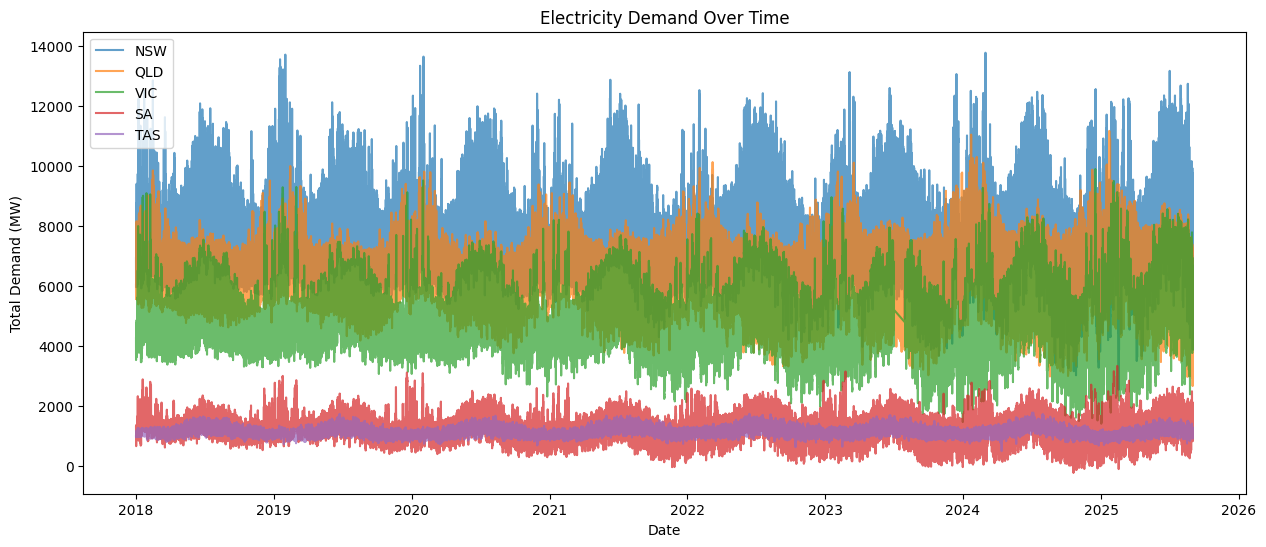

In [8]:
plt.figure(figsize=(15, 6))
plt.plot(NSW_data['SETTLEMENTDATE'], NSW_data['TOTALDEMAND'], label='NSW', alpha=0.7)
plt.plot(QLD_data['SETTLEMENTDATE'], QLD_data['TOTALDEMAND'], label='QLD', alpha=0.7)
plt.plot(VIC_data['SETTLEMENTDATE'], VIC_data['TOTALDEMAND'], label='VIC', alpha=0.7)
plt.plot(SA_data['SETTLEMENTDATE'], SA_data['TOTALDEMAND'], label='SA', alpha=0.7)
plt.plot(TAS_data['SETTLEMENTDATE'], TAS_data['TOTALDEMAND'], label='TAS', alpha=0.7)
plt.title('Electricity Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Total Demand (MW)')
plt.legend()
plt.show()

- SA and TAS are much smaller in terms of `totaldemand`

## Seasonality

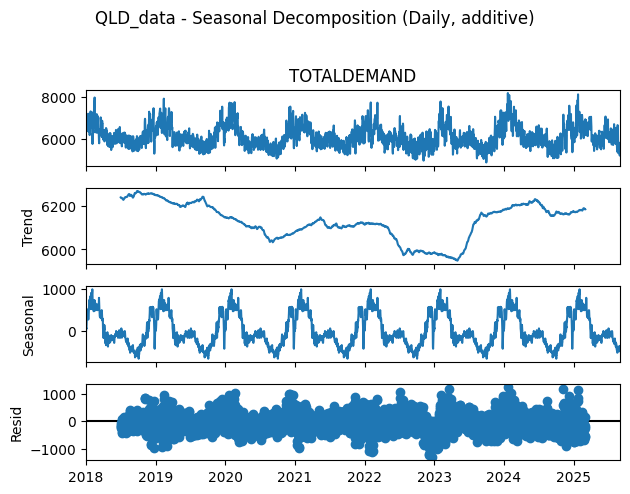

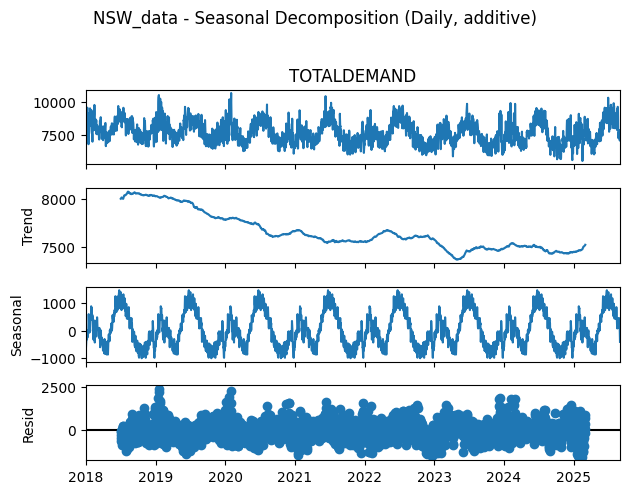

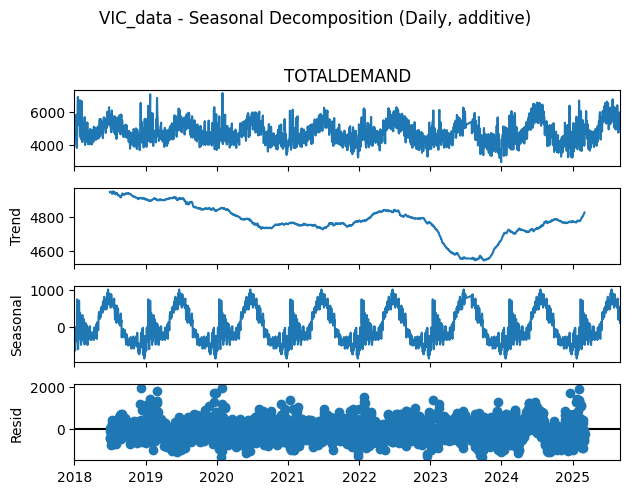

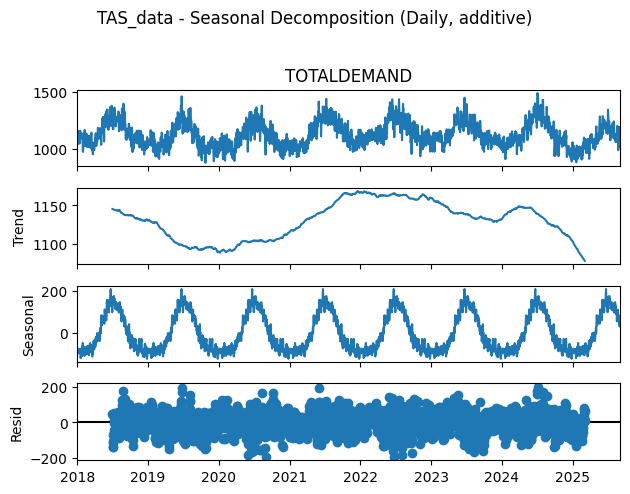

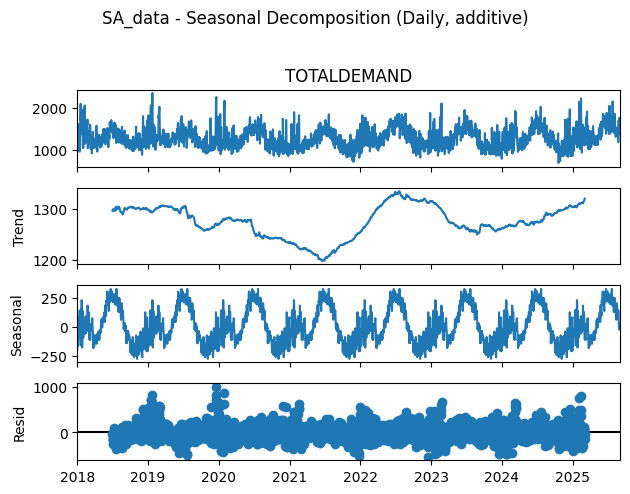

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

for name, df in dataset_list:
    df = df.sort_values('SETTLEMENTDATE').set_index('SETTLEMENTDATE')

    # Resample to daily average
    daily_mean = df['TOTALDEMAND'].resample('D').mean().dropna()

    # Seasonal decomposition (yearly cycle = 365 days for daily data)
    res = seasonal_decompose(daily_mean, model='additive', period=365)

    # Use built-in plotting
    fig = res.plot()
    fig.suptitle(f"{name} - Seasonal Decomposition (Daily, additive)", y=1.02)
    plt.tight_layout()
    plt.show()


- Trend: NSW/QLD/VIC dip through 2020–22 then recover; TAS/SA show a gentler arc. That’s consistent with COVID effects + rooftop PV uptake shifting daytime demand.

- Seasonality: Strong, repeating cycles—both weekly and annual are evident. On daily data the weekly pattern is still present; your classical additive decomp (one period) captured mostly annual seasonality.

- Residuals: Still autocorrelated (bursts around heatwaves/holidays). That means a single-season additive model won’t fully explain the structure.

**Next steps that will improve things**
- Use multiplicative seasonality (or log transform)—amplitude grows/shrinks with level in NSW/QLD.

- Model multiple seasonalities (weekly=7 and annual≈365/366) with MSTL or TBATS/Prophet rather than a single-period classical decompose.

- Check residual diagnostics: ACF/PACF of residuals; Ljung–Box; seasonal strength metrics.

- Downstream models: SARIMA with seasonal difference at 7 and possibly 365, or Regression-with-ARIMA-errors including weather/holiday features.

## Freq dynamics

In [10]:
# resample the data to quarter frequency and calculate the mean
NSW = NSW_data.sort_values('SETTLEMENTDATE').set_index('SETTLEMENTDATE')['TOTALDEMAND']
QLD = QLD_data.sort_values('SETTLEMENTDATE').set_index('SETTLEMENTDATE')['TOTALDEMAND']
VIC = VIC_data.sort_values('SETTLEMENTDATE').set_index('SETTLEMENTDATE')['TOTALDEMAND']
TAS = TAS_data.sort_values('SETTLEMENTDATE').set_index('SETTLEMENTDATE')['TOTALDEMAND']
SA = SA_data.sort_values('SETTLEMENTDATE').set_index('SETTLEMENTDATE')['TOTALDEMAND']

NSW_m = NSW.resample('M').mean().rename('NSW')
QLD_m = QLD.resample('M').mean().rename('QLD')
VIC_m = VIC.resample('M').mean().rename('VIC')
TAS_m = TAS.resample('M').mean().rename('TAS')
SA_m = SA.resample('M').mean().rename('SA')

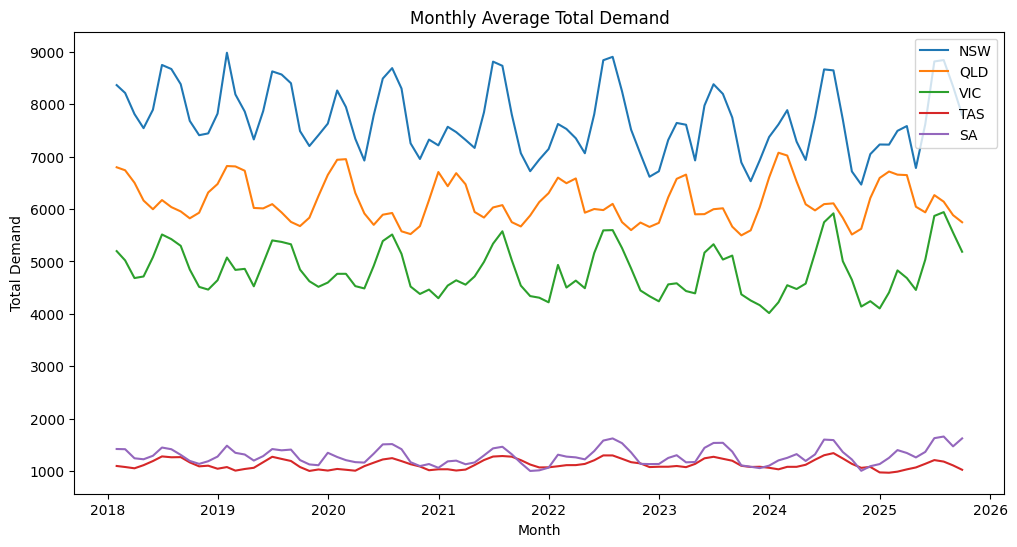

In [11]:
plt.figure(figsize=(12,6))
plt.plot(NSW_m.index, NSW_m.values, label='NSW')
plt.plot(QLD_m.index, QLD_m.values, label='QLD')
plt.plot(VIC_m.index, VIC_m.values, label='VIC')
plt.plot(TAS_m.index, TAS_m.values, label='TAS')
plt.plot(SA_m.index, SA_m.values, label='SA')
plt.title('Monthly Average Total Demand')
plt.xlabel('Month')
plt.ylabel('Total Demand')
plt.legend()
plt.show()

**Strong annual seasonality in all states**

- QLD & NSW track closely (high co-movement). VIC similar but with slightly larger winter amplitude in later years.

- SA & TAS are lower level but spikier (wind/solar + smaller system).

- A 2020–2022 dip then recovery appears across states (COVID + PV uptake effects).

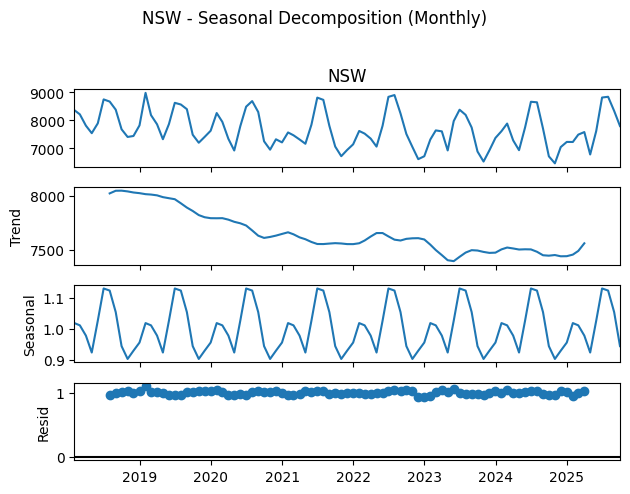

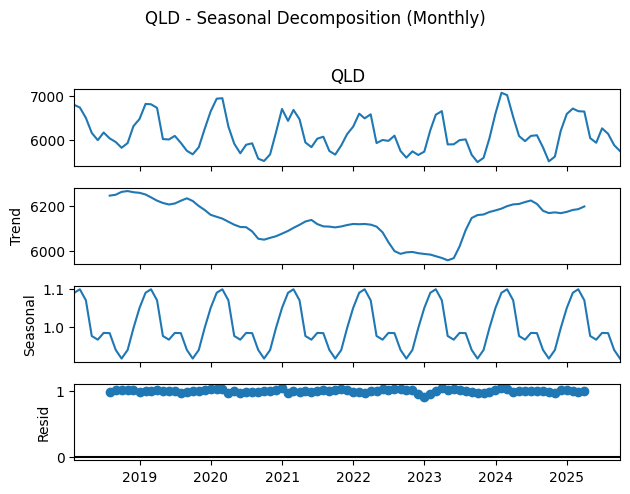

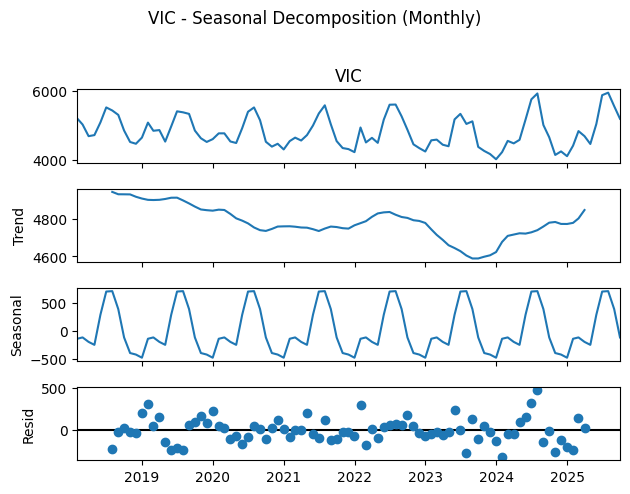

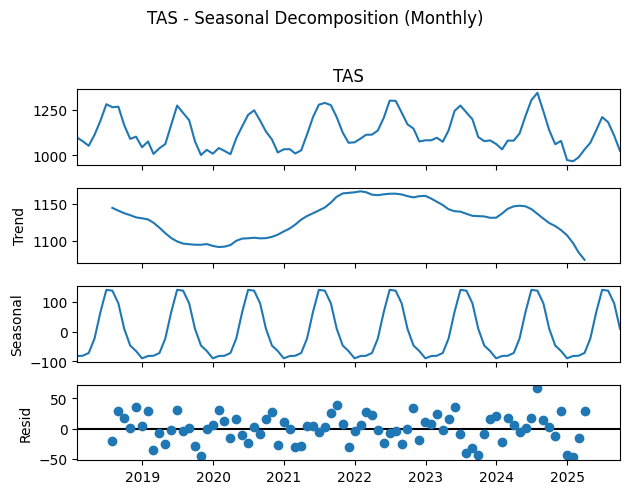

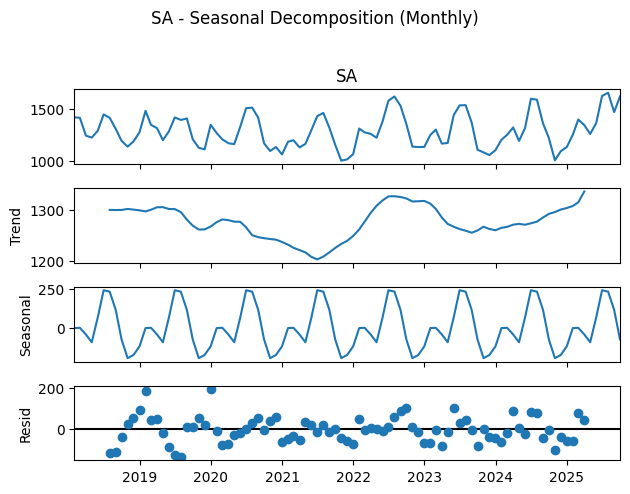

In [12]:
q_datalist = [("NSW", NSW_m), ("QLD", QLD_m), ("VIC", VIC_m), ("TAS", TAS_m), ("SA", SA_m)]

for name, df in q_datalist:
    y = df.sort_index().dropna()

    # NSW & QLD: multiplicative (ensure positivity), others: additive
    if name in {"NSW", "QLD"}:
        result = seasonal_decompose(y, model="multiplicative", period=12)
    else:
        result = seasonal_decompose(y, model="additive", period=12)

    # Use built-in plotting
    fig = result.plot()
    fig.suptitle(f"{name} - Seasonal Decomposition (Monthly)", y=1.02)
    plt.tight_layout()
    plt.show()


- Annual seasonality is strong across all states. Peaks in winter months; troughs in late spring/early summer are clear.

- **NSW & QLD benefit from multiplicative treatment**. Seasonal amplitude scales with level (winter peaks proportionally larger).

- COVID-era dip & recovery: Clear downtrend into ~2021–22 for NSW/VIC/SA, then rebound; QLD shows a sharper 2022–23 level shift.

- Residual autocorrelation remains. **Single-season classical decompose doesn’t remove weekly patterns or holiday/weather shocks**.

- TAS/SA: Lower absolute demand but relatively spikier residuals (small system + VRE variability).

# Time-series related EDA

In [13]:
train_cutoff = pd.to_datetime('2024-12-31')
target_end = pd.to_datetime('2025-09-02')  # 9 months

def split_by_index(s, train_start=None, train_cutoff=None, test_end=None):
    s = s.sort_index()
    if train_start is None:
        train_start = s.index.min()
    train = s.loc[(s.index >= train_start) & (s.index < train_cutoff)]
    test  = s.loc[(s.index >= train_cutoff) & (s.index <= test_end)]
    return train, test

NSW_train, NSW_test = split_by_index(NSW_m, train_cutoff=train_cutoff, test_end=target_end)
QLD_train, QLD_test = split_by_index(QLD_m, train_cutoff=train_cutoff, test_end=target_end)
VIC_train, VIC_test = split_by_index(VIC_m, train_cutoff=train_cutoff, test_end=target_end)
TAS_train, TAS_test = split_by_index(TAS_m, train_cutoff=train_cutoff, test_end=target_end)
SA_train, SA_test = split_by_index(SA_m, train_cutoff=train_cutoff, test_end=target_end)


print('NSW:', NSW_train.shape, NSW_test.shape)
print('QLD:', QLD_train.shape, QLD_test.shape)
print('VIC:', VIC_train.shape, VIC_test.shape)
print('TAS:', TAS_train.shape, TAS_test.shape)
print('SA:', SA_train.shape, SA_test.shape)

NSW: (83,) (9,)
QLD: (83,) (9,)
VIC: (83,) (9,)
TAS: (83,) (9,)
SA: (83,) (9,)


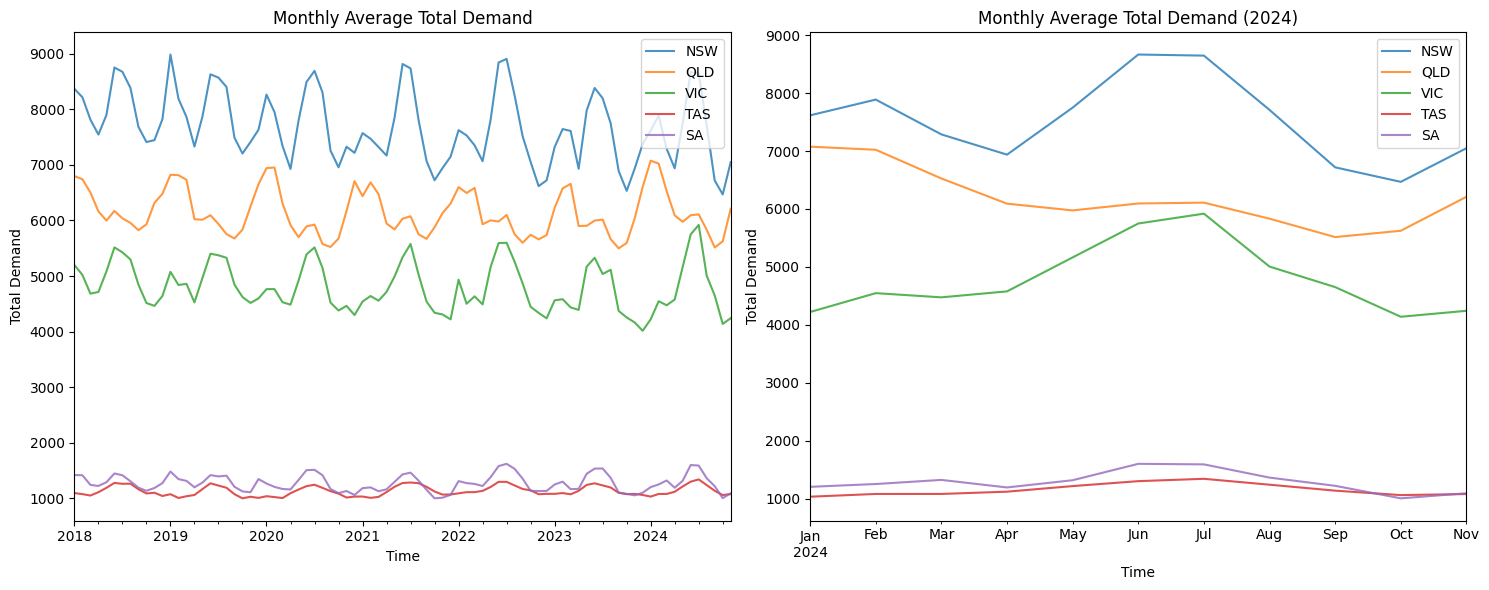

In [14]:
# plot the distribution of total demand over time for each state
train_list = {'NSW': NSW_train, 'QLD': QLD_train, 'VIC': VIC_train, 'TAS': TAS_train, 'SA': SA_train}
plt.figure(figsize=(15, 6))
plt.subplot(121)
for name, s in train_list.items():
    s.sort_index().plot(label=name, alpha=0.8)
plt.title("Monthly Average Total Demand")
plt.xlabel("Time"); plt.ylabel("Total Demand"); plt.legend()

plt.subplot(122)
start_date = '2024-01-01'
end_date   = '2024-12-31'

for name, s in train_list.items():
    s.sort_index().loc[start_date:end_date].plot(label=name, alpha=0.8)
plt.title("Monthly Average Total Demand (2024)")
plt.xlabel("Time"); plt.ylabel("Total Demand"); plt.legend()

plt.tight_layout()
plt.show()

- Clear winter peaks (Jun–Aug) across all states; NSW shows the largest seasonal swing, VIC second.

- QLD has a warmer-climate profile: smaller winter bump, flatter shoulders than NSW/VIC.

- SA/TAS lower level but spikier—small systems + VRE variability → bigger day-to-day swings.

- 2022 panel: NSW peaks ~Jun–Jul, VIC peak a touch later; QLD is flatter mid-year; SA/TAS ramp into winter then ease by Oct–Nov.

- Visual seasonality suggests **multiplicative effects for NSW/VIC** (amplitude scales with level). Consider logs or %-based seasonality for modeling.

## Stationary

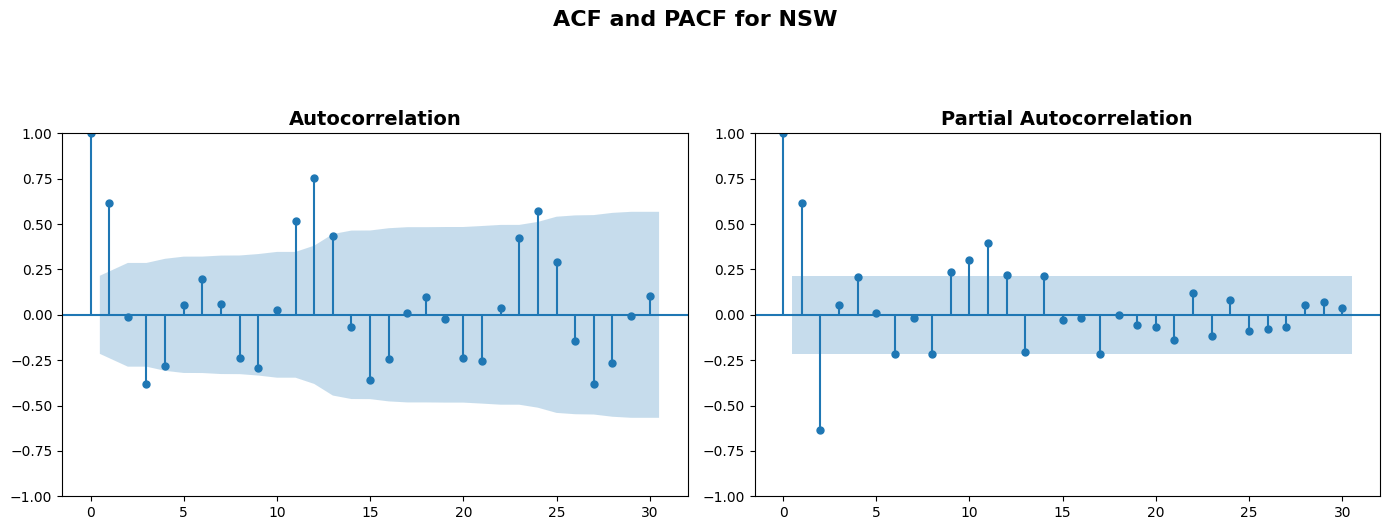

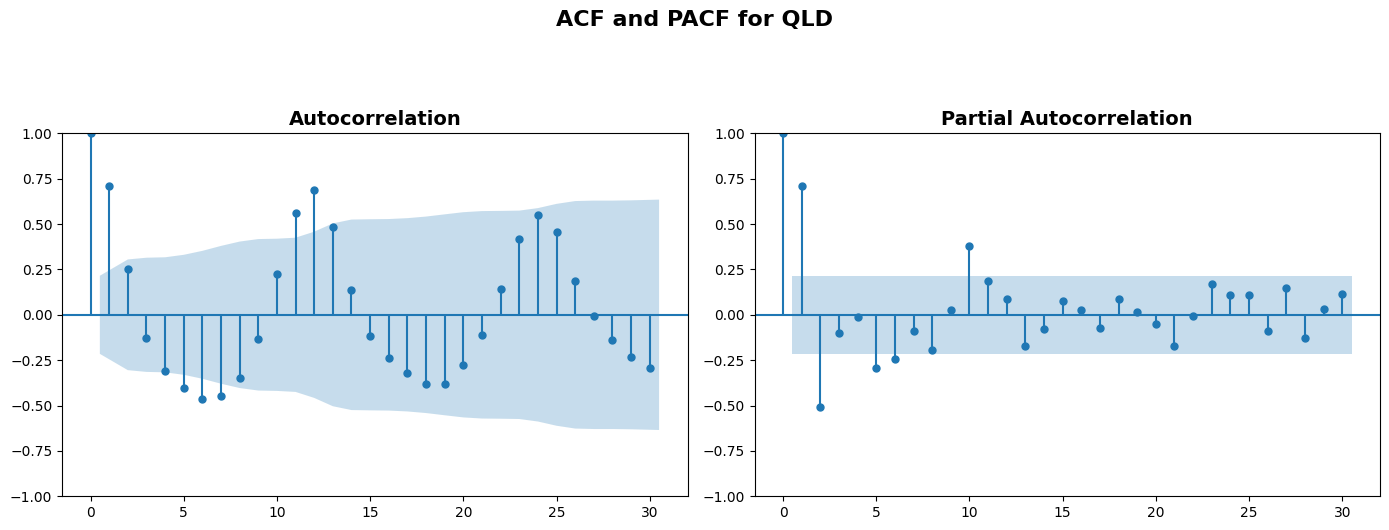

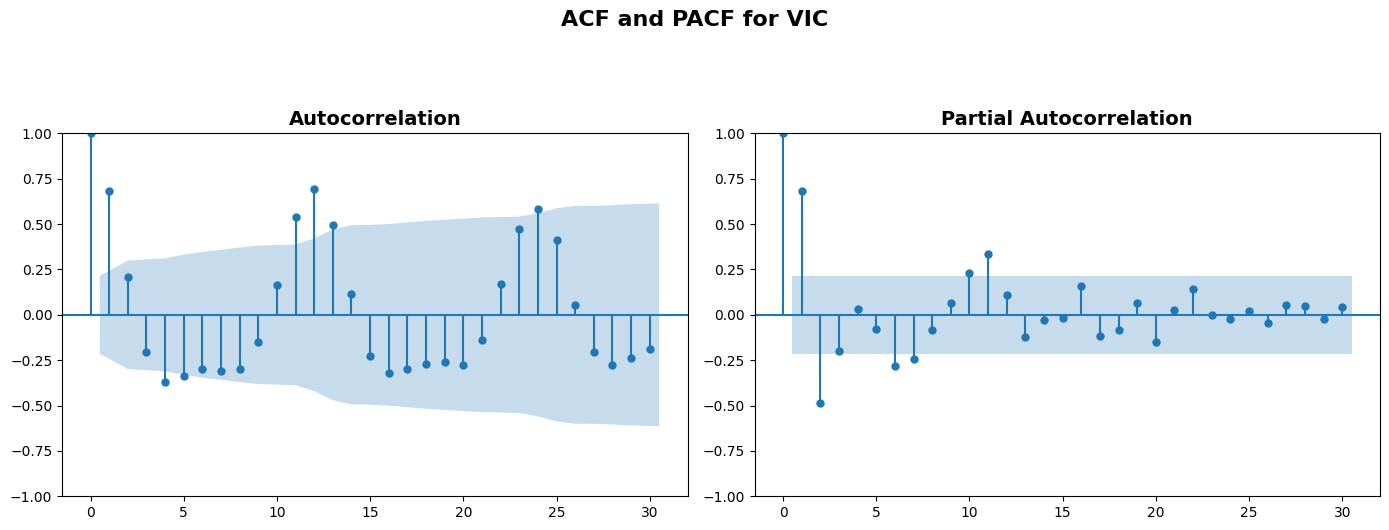

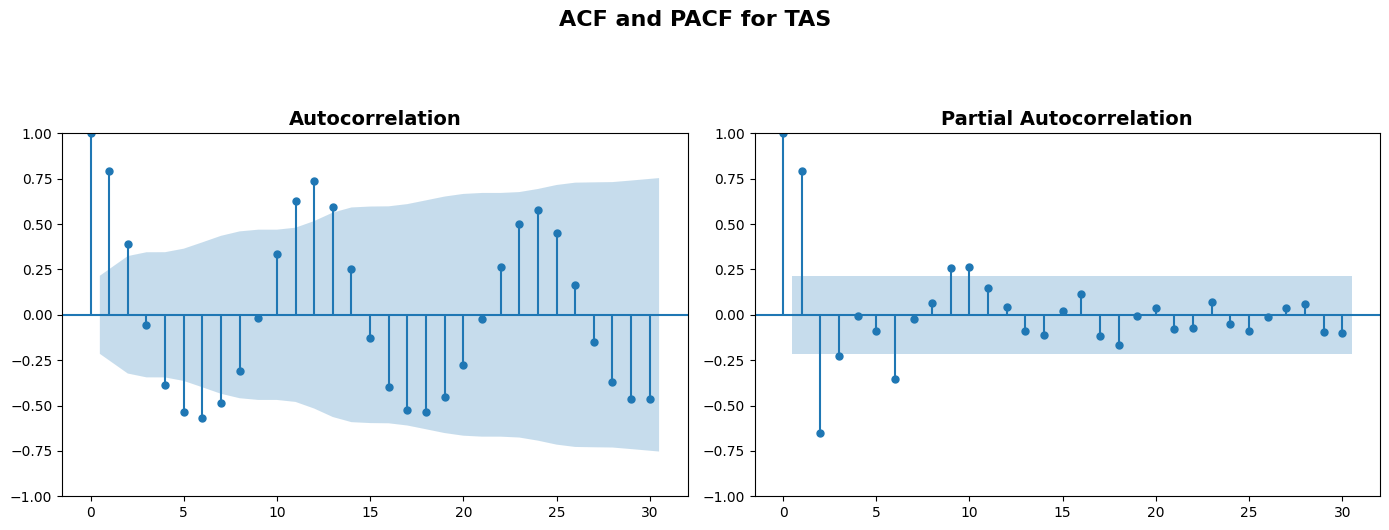

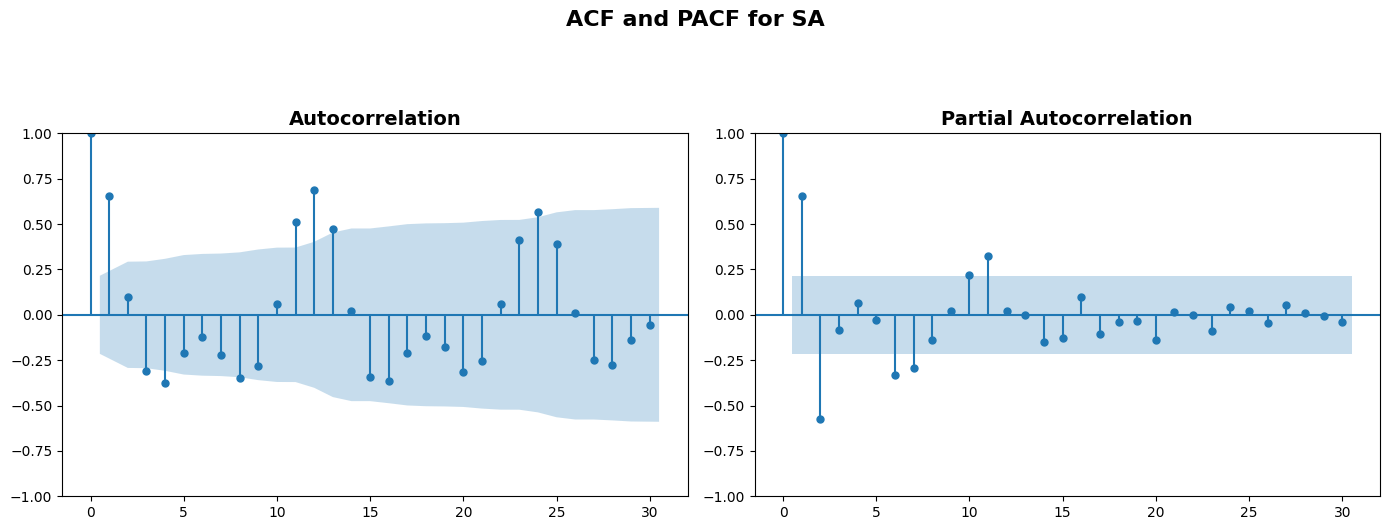

In [15]:
for name, series in train_list.items():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
    
    sm.graphics.tsa.plot_acf(series, lags=30, alpha=0.05, ax=ax1)
    ax1.set_title("Autocorrelation", fontsize=14, fontweight="bold")
    
    sm.graphics.tsa.plot_pacf(series, lags=30, alpha=0.05, ax=ax2, method="ywm")
    ax2.set_title("Partial Autocorrelation", fontsize=14, fontweight="bold")
    
    fig.suptitle(f"ACF and PACF for {name}", fontsize=16, fontweight="bold", y=1.05)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

In [16]:
# adfuller test: statistical test used to determine if a time series is stationary or not by testing for the presence of a unit root. 
# The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root. 
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

adf_results = []

for name, series in train_list.items():
    test = adfuller(series.dropna())
    adf_results.append({
        'name': name,
        'statistic': test[0],   #ADF test statistic
        'pvalue': test[1],      # p-value that the series has a unit root (aka non-stationary)
        'n_lags': test[2],      # number of lags used in the test
        'n_obs': test[3],       # number of observations used in the test
        'crit_1%': test[4]['1%'],
        'crit_5%': test[4]['5%'],
        'crit_10%': test[4]['10%']
    })

df_adf = pd.DataFrame(adf_results)
print(df_adf)

  name  statistic    pvalue  n_lags  n_obs   crit_1%   crit_5%  crit_10%
0  NSW  -2.141158  0.228290      12     70 -3.527426 -2.903811 -2.589320
1  QLD  -1.627533  0.468782      10     72 -3.524624 -2.902607 -2.588679
2  VIC  -1.457029  0.554651      11     71 -3.526005 -2.903200 -2.588995
3  TAS  -1.065879  0.728485      12     70 -3.527426 -2.903811 -2.589320
4   SA  -1.649679  0.457208      10     72 -3.524624 -2.902607 -2.588679


### Differencing

In [17]:
m = 12 # monthly data, yearly seasonality
NSW_diff = NSW_train.diff(m).dropna()
QLD_diff = QLD_train.diff(m).dropna()
VIC_diff = VIC_train.diff(m).dropna()
TAS_diff = TAS_train.diff(m).dropna()
SA_diff = SA_train.diff(m).dropna()

# re-test stationarity after differencing
adf_results_diff = []
for name, series in zip(['NSW', 'QLD', 'VIC', 'TAS', 'SA'], [NSW_diff, QLD_diff, VIC_diff, TAS_diff, SA_diff]):
    test = adfuller(series.dropna())
    adf_results_diff.append({
        'name': name,
        'statistic': test[0],
        'pvalue': test[1],
        'n_lags': test[2],
        'n_obs': test[3],
        'crit_1%': test[4]['1%'],
        'crit_5%': test[4]['5%'],
        'crit_10%': test[4]['10%']
    })

df_adf_diff = pd.DataFrame(adf_results_diff)
print(df_adf_diff)

  name  statistic    pvalue  n_lags  n_obs   crit_1%   crit_5%  crit_10%
0  NSW  -4.828439  0.000048       3     67 -3.531955 -2.905755 -2.590357
1  QLD  -3.684246  0.004340      11     59 -3.546395 -2.911939 -2.593652
2  VIC  -3.749358  0.003470      11     59 -3.546395 -2.911939 -2.593652
3  TAS  -3.854061  0.002400       0     70 -3.527426 -2.903811 -2.589320
4   SA  -2.871074  0.048817      12     58 -3.548494 -2.912837 -2.594129


Seasonal differencing makes the data stationary -> m = 12

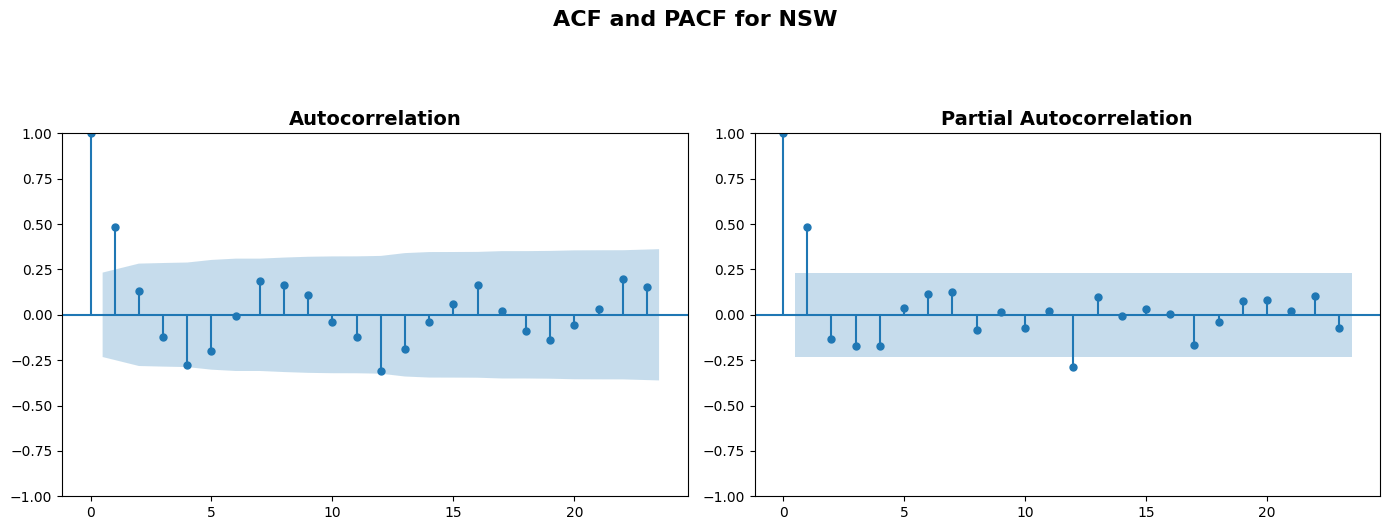

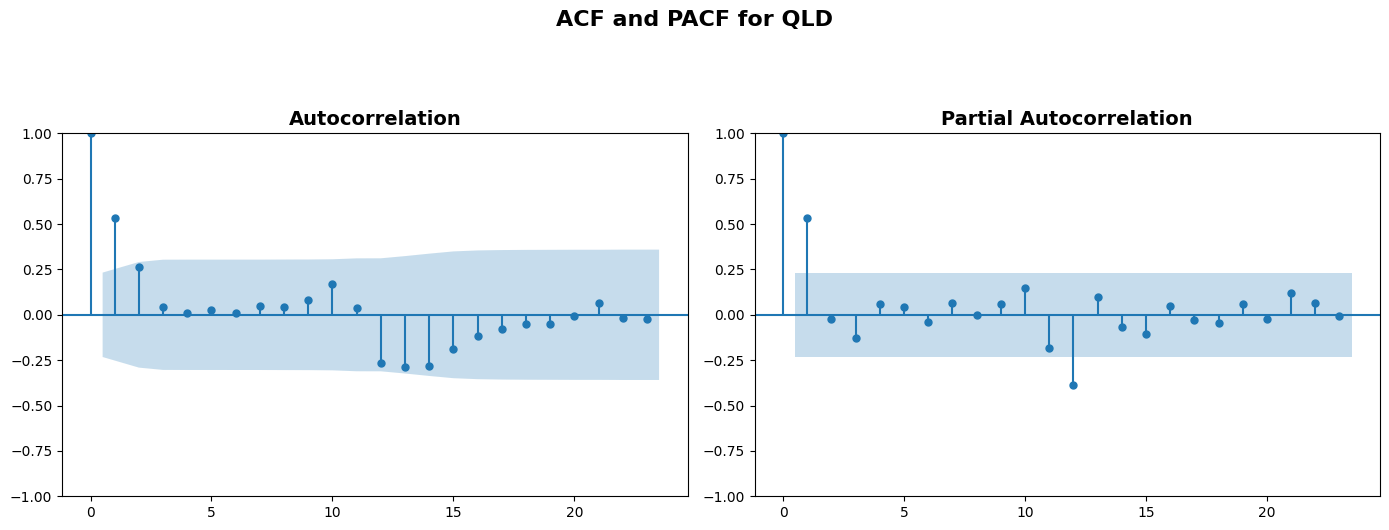

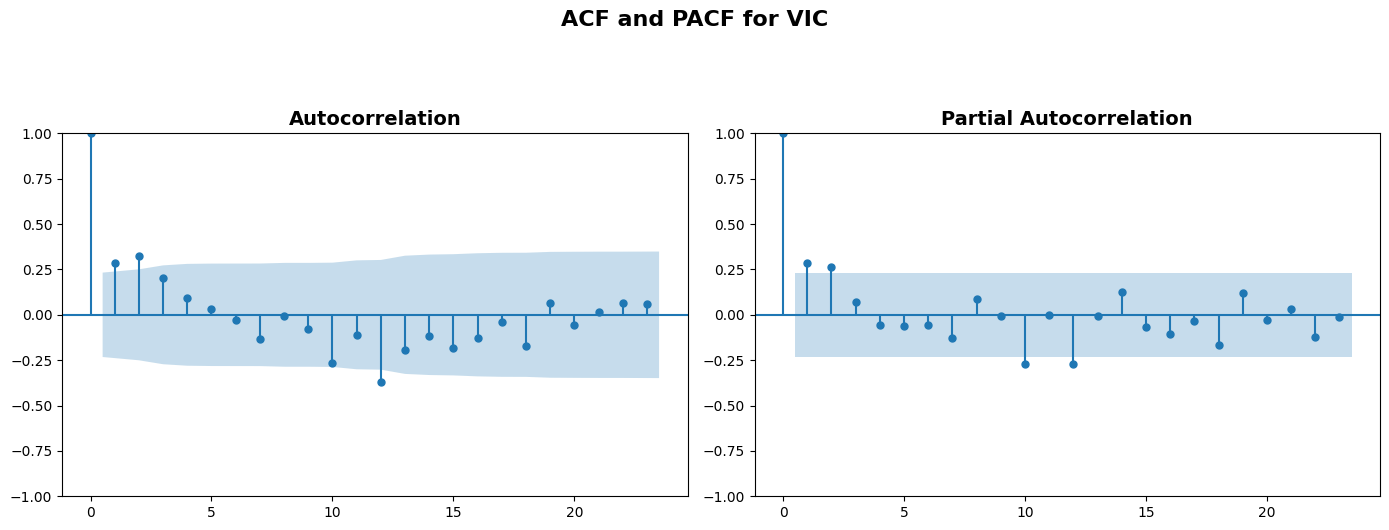

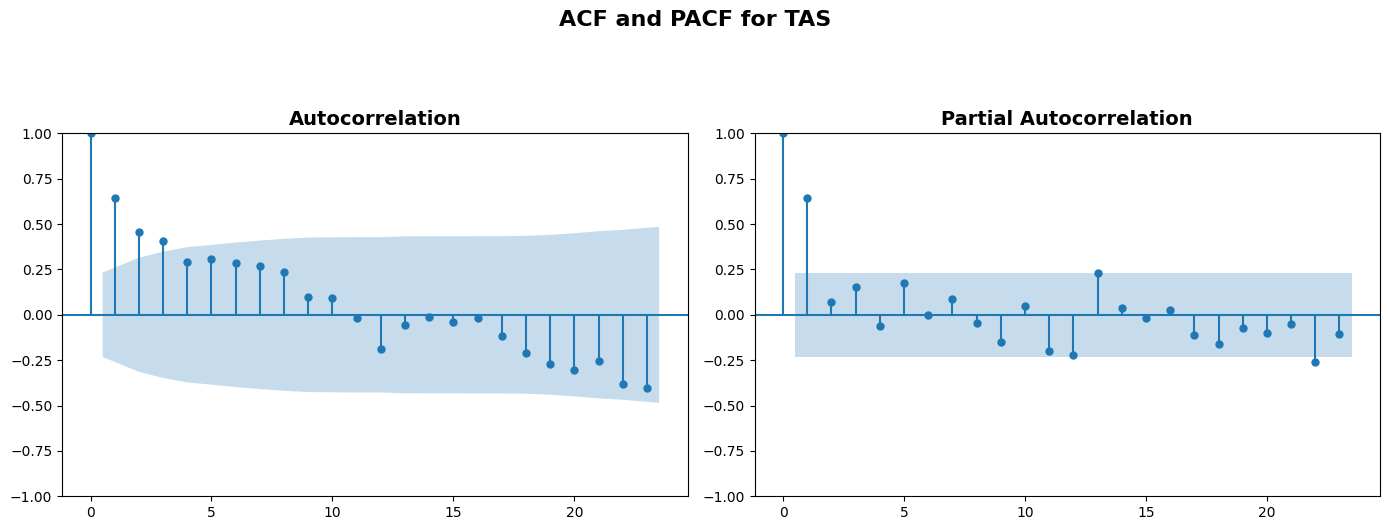

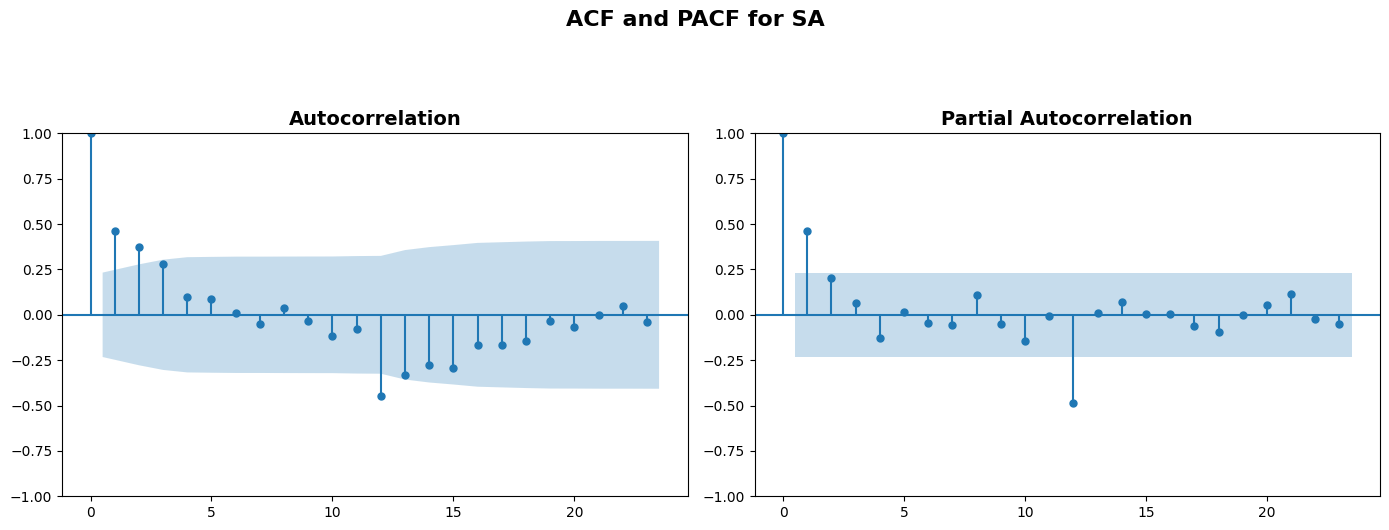

In [18]:
diff_list = {'NSW': NSW_diff, 'QLD': QLD_diff, 'VIC': VIC_diff, 'TAS': TAS_diff, 'SA': SA_diff}

for name, series in diff_list.items():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
    
    # ACF
    sm.graphics.tsa.plot_acf(series, lags=23, alpha=0.05, ax=ax1)
    ax1.set_title("Autocorrelation", fontsize=14, fontweight="bold")
    
    # PACF
    sm.graphics.tsa.plot_pacf(series, lags=23, alpha=0.05, ax=ax2, method="ywm")
    ax2.set_title("Partial Autocorrelation", fontsize=14, fontweight="bold")
    
    fig.suptitle(f"ACF and PACF for {name}", fontsize=16, fontweight="bold", y=1.05)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

# Time-series modelling
## Seasonal RW

In [19]:
season_length = 12 # monthly data with yearly seasonality
seasonal_rw_df = pd.DataFrame(index=NSW_test.index)

for name, series in train_list.items():
    history = series.dropna()
    forecast = []

    for h in range(1, len(NSW_test) + 1): 
        k = ((h - 1) // season_length) + 1
        index = -season_length * k

        if abs(index) >= len(history):
            yhat = history.iloc[-1] # fallback to last observation
        else: 
            yhat = history.iloc[index]

        forecast.append(yhat)

    seasonal_rw_df[name] = forecast

In [20]:
seasonal_rw_df

NSW          QLD          VIC          TAS           SA
SETTLEMENTDATE                                                                
2024-12-31      7375.32517  6602.150119  4015.373943  1062.466868  1103.169298
2025-01-31      7375.32517  6602.150119  4015.373943  1062.466868  1103.169298
2025-02-28      7375.32517  6602.150119  4015.373943  1062.466868  1103.169298
2025-03-31      7375.32517  6602.150119  4015.373943  1062.466868  1103.169298
2025-04-30      7375.32517  6602.150119  4015.373943  1062.466868  1103.169298
2025-05-31      7375.32517  6602.150119  4015.373943  1062.466868  1103.169298
2025-06-30      7375.32517  6602.150119  4015.373943  1062.466868  1103.169298
2025-07-31      7375.32517  6602.150119  4015.373943  1062.466868  1103.169298
2025-08-31      7375.32517  6602.150119  4015.373943  1062.466868  1103.169298

In [21]:
# Accurcy metrics
def mae(a, b): 
    return np.mean(np.abs(a - b))

def rmse(a, b): 
    return np.sqrt(np.mean((a - b) ** 2))

def mape(a, b): 
    return np.mean(np.abs((a - b) / a)) * 100

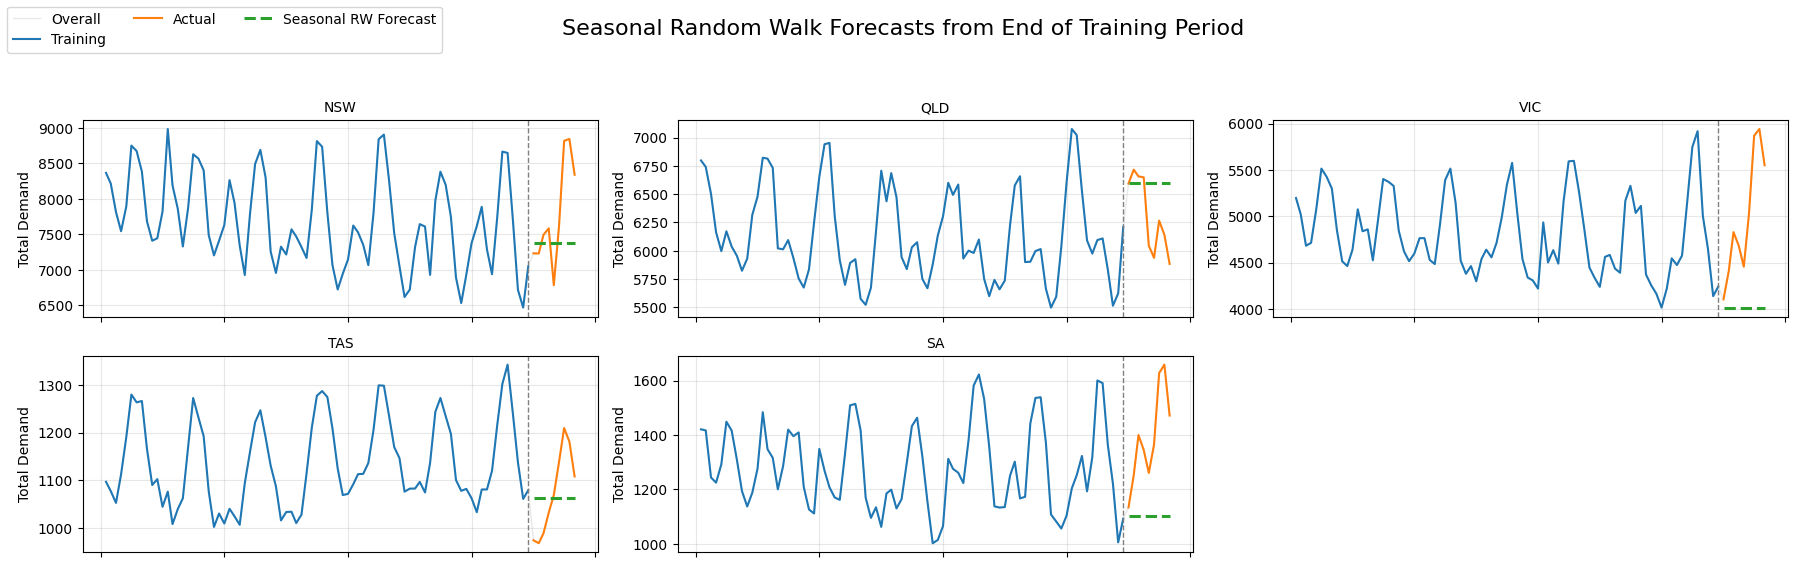

In [22]:
test_list =  {'NSW': NSW_test, 'QLD': QLD_test, 'VIC': VIC_test, 'TAS': TAS_test, 'SA': SA_test}
results = pd.DataFrame(columns=['Region', 'MAE', 'RMSE', 'MAPE'])

forecast_model_df_seasonal = seasonal_rw_df

names = list(train_list.keys())  # ['NSW','QLD','VIC']
n_cols = 3
n_rows = int(np.ceil(len(names) / n_cols))

fig, axes = plt.subplots(3, n_cols, figsize=(18, 4 * n_rows), sharex=True)
axes = np.atleast_1d(axes).ravel()

def idx_to_ts(s):
    idx = s.index
    return idx.to_timestamp() if hasattr(idx, 'to_timestamp') else idx

for i, name in enumerate(names):
    ax = axes[i]

    tr = train_list[name]                       # Series
    te = test_list[name]                        # Series
    fc = forecast_model_df_seasonal[name]       # Series or DataFrame column

    # X values (handle PeriodIndex or DatetimeIndex)
    x_tr = idx_to_ts(tr)
    x_te = idx_to_ts(te)
    x_fc = idx_to_ts(fc)
    
    # Ensure test and forecast data align for error metrics
    common_index = te.index.intersection(fc.index)
    te_aligned = te.loc[common_index]
    fc_aligned = fc.loc[common_index]
    
    # Calculate error metrics
    mae_value = mae(te_aligned.values, fc_aligned.values)
    rmse_value = rmse(te_aligned.values, fc_aligned.values)
    mape_value = mape(te_aligned.values, fc_aligned.values)
    
    # Append to results DataFrame
    results = pd.concat([results, pd.DataFrame({
        'Region': [name],
        'MAE': [mae_value],
        'RMSE': [rmse_value],
        'MAPE': [mape_value]
    })], ignore_index=True)
    
    combined = pd.concat([tr, te])
    ax.plot(combined.index, combined.values, color='lightgray', alpha=0.5, label='Overall', lw=1)

    ax.plot(x_tr, tr.values, label='Training', color='#1f77b4', lw=1.5)
    ax.plot(x_te, te.values, label='Actual',   color='#ff7f0e', lw=1.5)
    ax.plot(x_fc, fc.values, label='Seasonal RW Forecast',
            color='#2ca02c', lw=2.2, ls='--')

    # vertical split marker at end of training
    ax.axvline(x_tr[-1], color='gray', ls='--', lw=1)

    ax.set_title(name, fontsize=10)
    ax.set_ylabel('Total Demand')
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Global legend and title
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=3, fontsize=10)
fig.suptitle("Seasonal Random Walk Forecasts from End of Training Period", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

In [23]:
# Display results sorted by RMSE
results = results.sort_values('RMSE')
print("Forecasting Performance Metrics for Random Walk:")
print(results)

Forecasting Performance Metrics for Random Walk:
  Region         MAE         RMSE       MAPE
3    TAS   75.526024    85.964671   6.969484
4     SA  287.467740   330.570285  19.584880
1    QLD  328.986940   423.180342   5.426196
0    NSW  591.868684   794.097119   7.197243
2    VIC  971.286750  1155.346505  18.226311


## SES

In [24]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

ses_models, fc_ses_dict = {}, {}
rows_ses = []

for name in train_list.keys():
    tr = train_list[name].astype(float).copy()
    te = test_list[name].astype(float).copy()
    h  = len(te)

    ses = SimpleExpSmoothing(tr, initialization_method="estimated").fit(optimized=True)
    ses_models[name] = ses

    fc_ses = ses.forecast(h)
    fc_ses.index = te.index
    fc_ses_dict[name] = fc_ses

    rows_ses.append({
        "region": name,
        "model": "SES (level-only)",
        "AIC": ses.aic,
        "MAE": mae(te, fc_ses),
        "RMSE": rmse(te, fc_ses),
        "MAPE": mape(te, fc_ses)
    })

result_ses = pd.DataFrame(rows_ses)
result_ses


region             model          AIC         MAE         RMSE       MAPE
0    NSW  SES (level-only)  1049.960054  784.418672  1000.457687   9.508396
1    QLD  SES (level-only)   949.007153  296.408469   336.236736   4.620391
2    VIC  SES (level-only)   969.415955  775.563336   972.882045  14.362499
3    TAS  SES (level-only)   674.933657   75.909131    85.251514   7.113289
4     SA  SES (level-only)   804.698183  298.032856   339.797874  20.355021

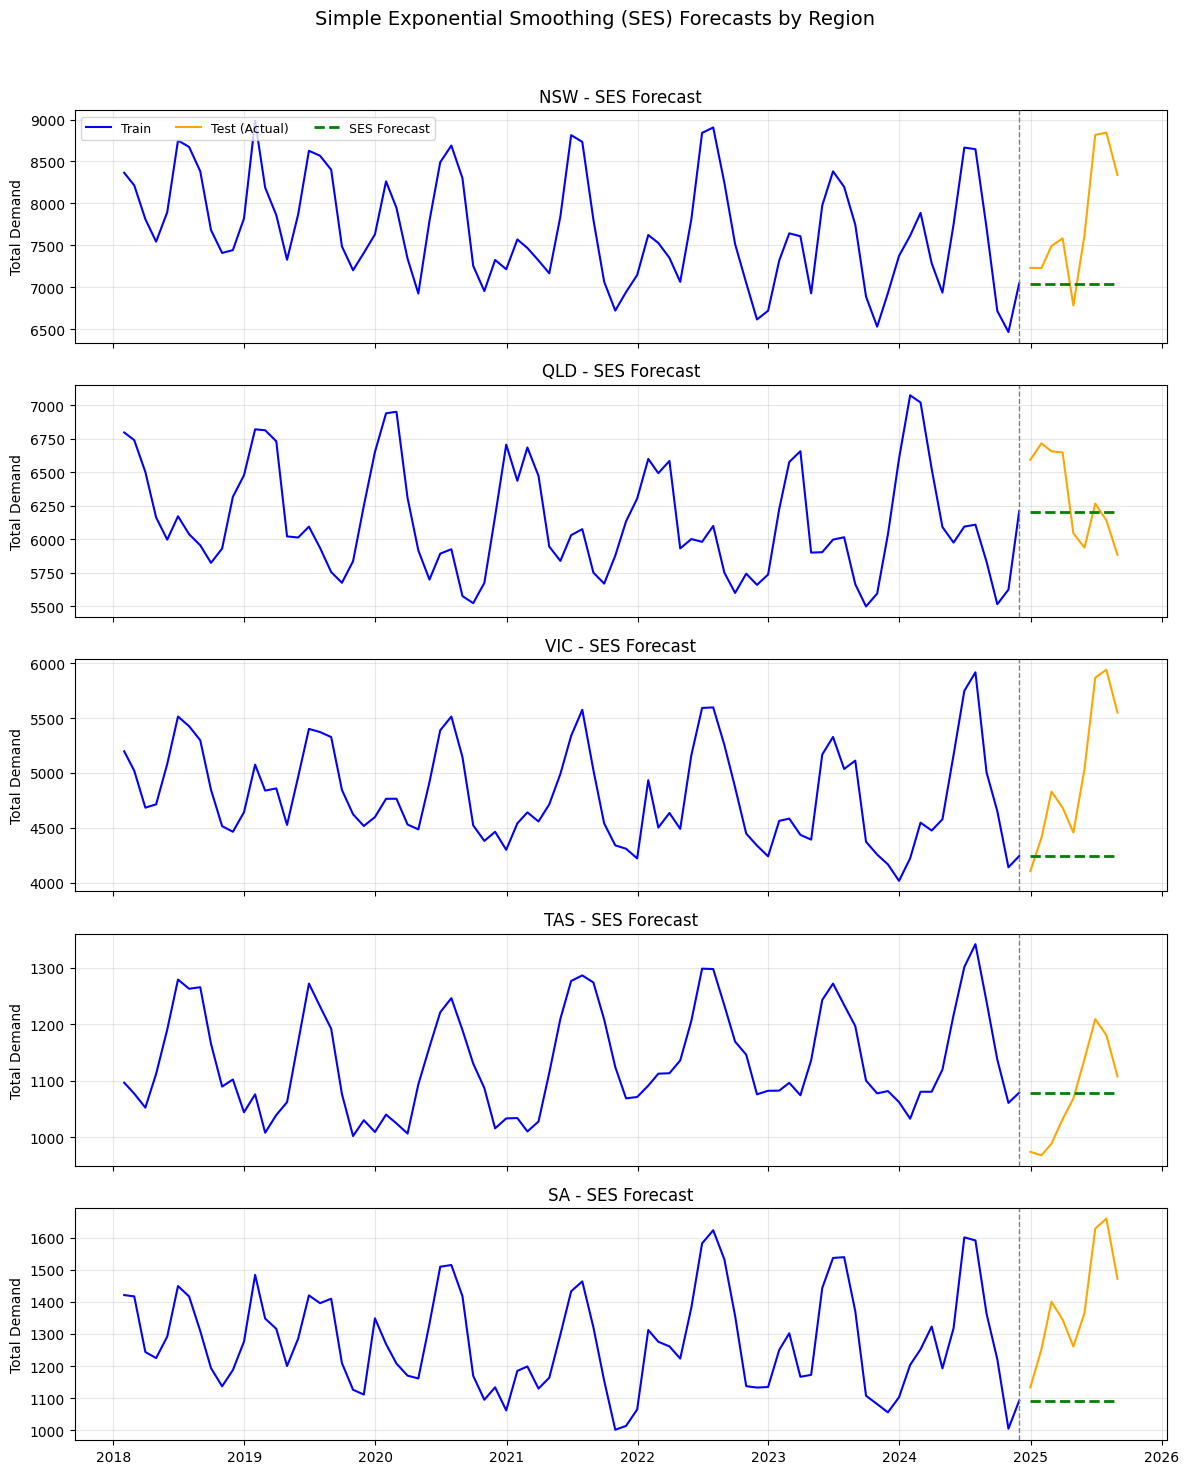

In [25]:
fig, axes = plt.subplots(len(train_list), 1, figsize=(12, 3*len(train_list)), sharex=True)

if len(train_list) == 1:
    axes = [axes]  # ensure iterable if only one region

for i, name in enumerate(train_list.keys()):
    ax = axes[i]

    tr = train_list[name]
    te = test_list[name]
    fc = fc_ses_dict[name]

    # Plot training, test, and forecast
    ax.plot(tr.index, tr.values, label="Train", color="blue", lw=1.5)
    ax.plot(te.index, te.values, label="Test (Actual)", color="orange", lw=1.5)
    ax.plot(fc.index, fc.values, label="SES Forecast", color="green", lw=2, ls="--")

    # Mark cutoff
    ax.axvline(tr.index[-1], color="gray", ls="--", lw=1)

    ax.set_title(f"{name} - SES Forecast", fontsize=12)
    ax.set_ylabel("Total Demand")
    ax.grid(alpha=0.3)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

axes[0].legend(loc="upper left", ncol=3, fontsize=9)
plt.suptitle("Simple Exponential Smoothing (SES) Forecasts by Region", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Holt winter

In [26]:
hw_models, fc_hw_dict = {}, {}
rows_hw = []

for name in train_list.keys():
    tr = train_list[name].astype(float).copy()
    te = test_list[name].astype(float).copy()
    h  = len(te)
    sp = 12

    # choose seasonal type by region
    seasonal_type = "mul" if name in ["NSW", "QLD"] else "add"

    # --- Fit HW (level + seasonal, no trend) ---
    hw = ExponentialSmoothing(
        tr, seasonal=seasonal_type, seasonal_periods=sp,
        initialization_method="estimated"
    ).fit(optimized=True)
    hw_models[name] = hw

    # --- Forecast ---
    fc_hw = hw.forecast(h)
    fc_hw.index = te.index
    fc_hw_dict[name] = fc_hw

    # --- Metrics ---
    rows_hw.append({
        "region": name,
        "model": "HW seasonal",
        "AIC": hw.aic,
        "MAE": mae(te, fc_hw),
        "RMSE": rmse(te, fc_hw),
        "MAPE": mape(te, fc_hw)
    })

result_hw = pd.DataFrame(rows_hw)
result_hw


region        model         AIC         MAE        RMSE      MAPE
0    NSW  HW seasonal  924.524818  278.555283  322.011633  3.526165
1    QLD  HW seasonal  862.013273   81.213523   99.234610  1.277703
2    VIC  HW seasonal  870.795744  323.409104  382.434927  6.121936
3    TAS  HW seasonal  559.218777   75.536637   80.332219  7.065022
4     SA  HW seasonal  716.713658  104.436371  120.761390  7.195039

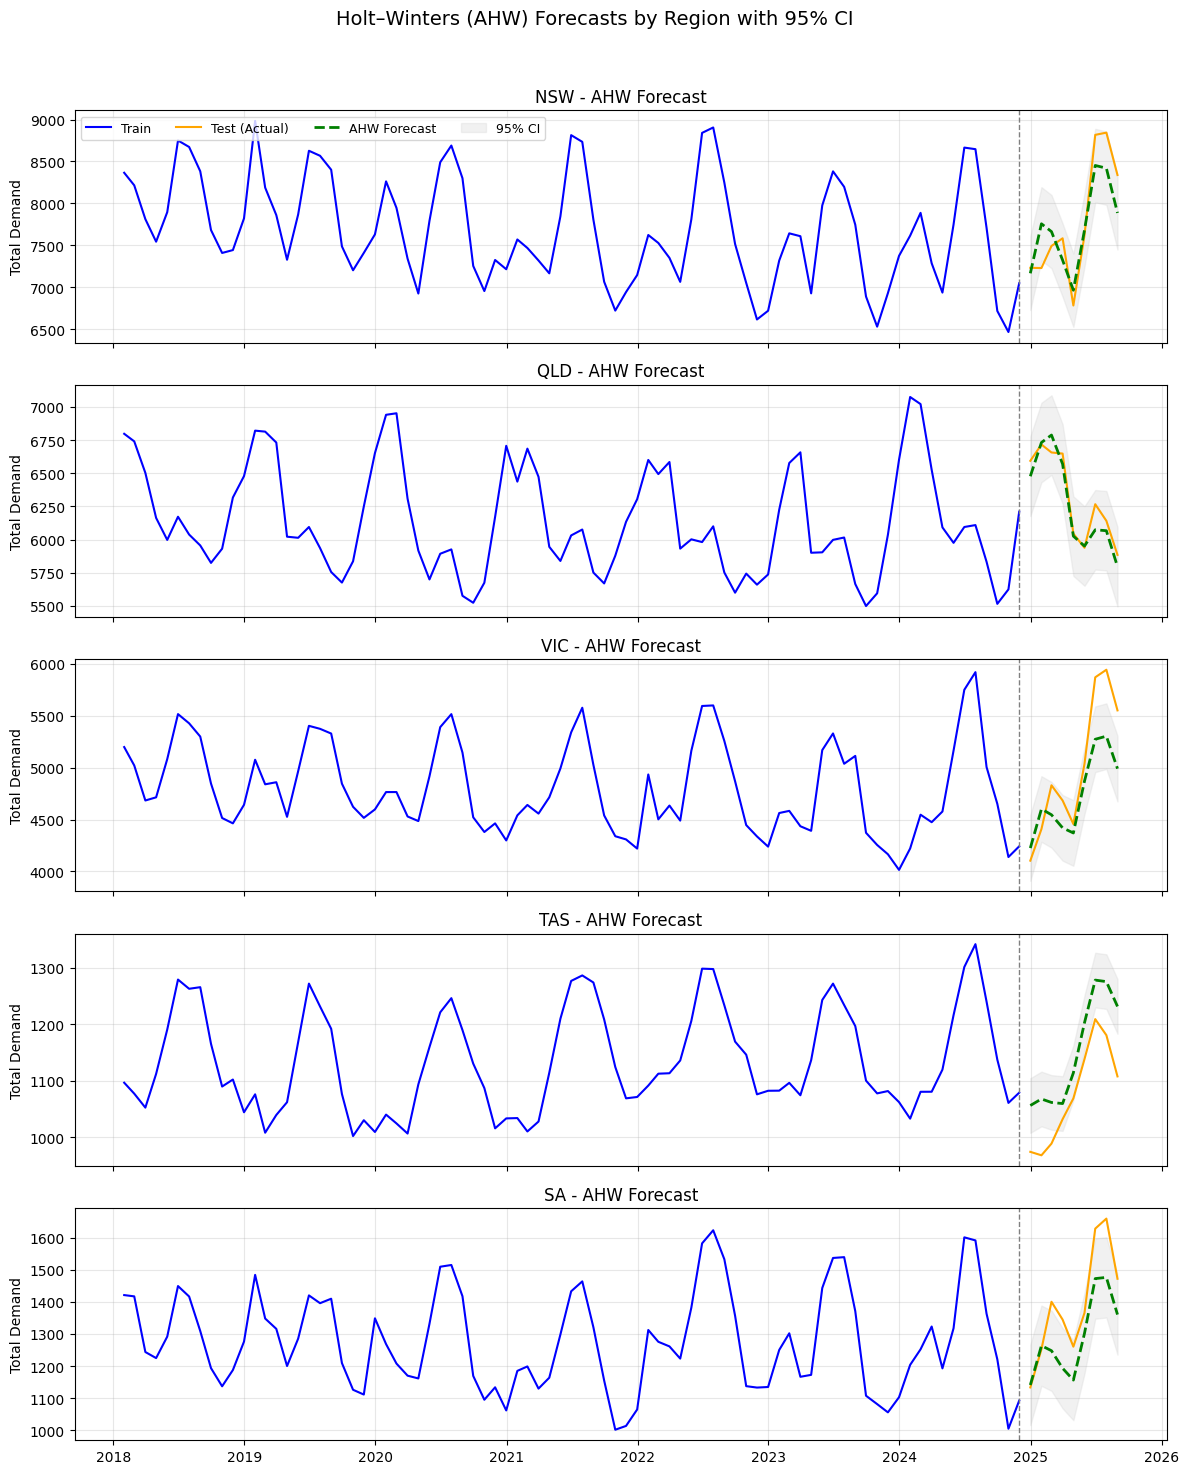

In [27]:
fig, axes = plt.subplots(len(train_list), 1, figsize=(12, 3*len(train_list)), sharex=True)

if len(train_list) == 1:
    axes = [axes]

for i, name in enumerate(train_list.keys()):
    ax = axes[i]

    tr = train_list[name]
    te = test_list[name]
    fc = fc_hw_dict[name]          
    model = hw_models[name]         

    # Residual std for CI
    sigma = np.std(model.resid, ddof=1)
    fc_lower, fc_upper = fc - 1.96*sigma, fc + 1.96*sigma

    # Plot train, test, forecast + CI
    ax.plot(tr.index, tr.values, label="Train", color="blue", lw=1.5)
    ax.plot(te.index, te.values, label="Test (Actual)", color="orange", lw=1.5)
    ax.plot(fc.index, fc.values, label="AHW Forecast", color="green", lw=2, ls="--")
    ax.fill_between(fc.index, fc_lower, fc_upper, color="lightgray", alpha=0.3, label="95% CI")

    # Mark cutoff
    ax.axvline(tr.index[-1], color="gray", ls="--", lw=1)

    ax.set_title(f"{name} - AHW Forecast", fontsize=12)
    ax.set_ylabel("Total Demand")
    ax.grid(alpha=0.3)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

axes[0].legend(loc="upper left", ncol=4, fontsize=9)
plt.suptitle("Holt–Winters (AHW) Forecasts by Region with 95% CI", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## AHW with damped trend

In [28]:
hwd_models, fc_hwd_dict = {}, {}
rows_hwd = []

for name in train_list.keys():
    tr = train_list[name].astype(float).copy()
    te = test_list[name].astype(float).copy()
    h  = len(te)
    sp = 12

    # choose seasonal type by region
    seasonal_type = "mul" if name in ["NSW", "QLD"] else "add"

    hwd = ExponentialSmoothing(
        tr, trend='add', damped_trend=True,
        seasonal=seasonal_type, seasonal_periods=sp,
        initialization_method="estimated"
    ).fit(optimized=True)
    hwd_models[name] = hwd

    fc_hwd = hwd.forecast(h)
    fc_hwd.index = te.index
    fc_hwd_dict[name] = fc_hwd

    rows_hwd.append({
        "region": name,
        "AIC": hwd.aic,
        "MAE": mae(te, fc_hwd),
        "RMSE": rmse(te, fc_hwd),
        "MAPE": mape(te, fc_hwd)
    })

result_hw = pd.DataFrame(rows_hwd)
result_hw


region         AIC         MAE        RMSE      MAPE
0    NSW  930.624014  283.617778  329.506145  3.584538
1    QLD  866.853337   84.326296  102.140888  1.326359
2    VIC  876.529713  321.141721  380.568992  6.077945
3    TAS  564.425053   75.400866   80.195445  7.048103
4     SA  728.213233  127.195535  145.333446  8.758003

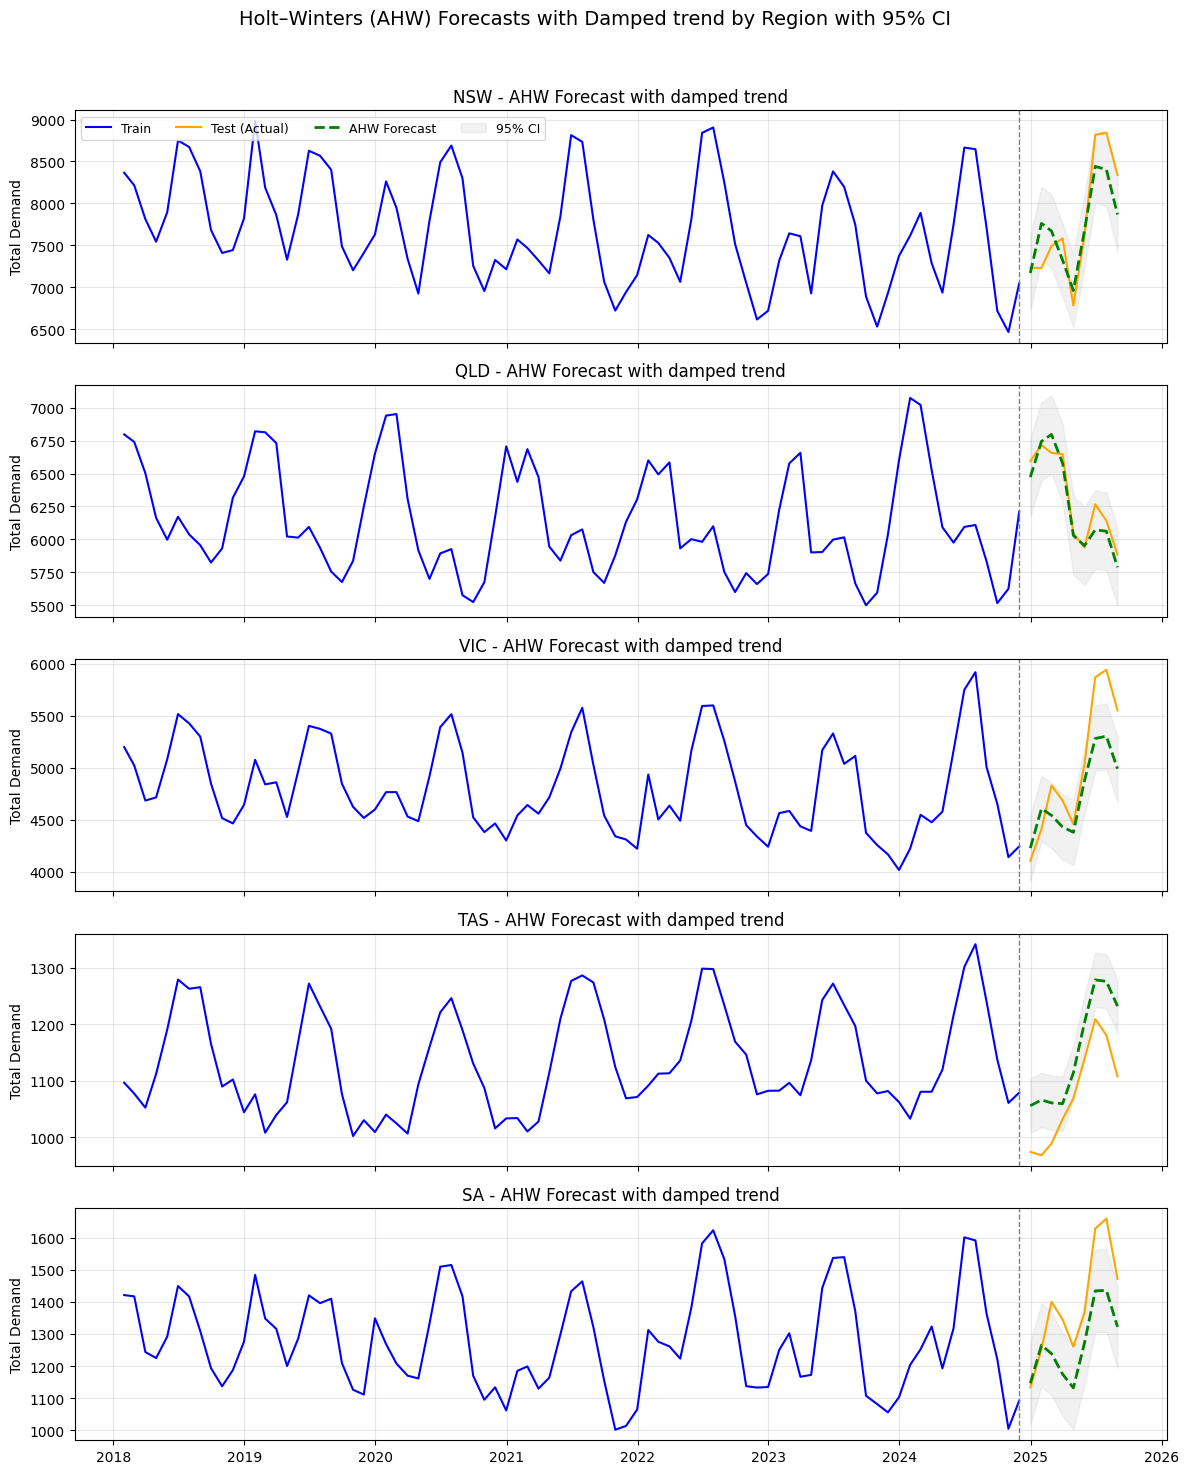

In [29]:
fig, axes = plt.subplots(len(train_list), 1, figsize=(12, 3*len(train_list)), sharex=True)

if len(train_list) == 1:
    axes = [axes]

for i, name in enumerate(train_list.keys()):
    ax = axes[i]

    tr = train_list[name]
    te = test_list[name]
    fc = fc_hwd_dict[name]       
    model = hwd_models[name]   

    # Residual std for CI
    sigma = np.std(model.resid, ddof=1)
    fc_lower, fc_upper = fc - 1.96*sigma, fc + 1.96*sigma

    # Plot train, test, forecast + CI
    ax.plot(tr.index, tr.values, label="Train", color="blue", lw=1.5)
    ax.plot(te.index, te.values, label="Test (Actual)", color="orange", lw=1.5)
    ax.plot(fc.index, fc.values, label="AHW Forecast", color="green", lw=2, ls="--")
    ax.fill_between(fc.index, fc_lower, fc_upper, color="lightgray", alpha=0.3, label="95% CI")

    # Mark cutoff
    ax.axvline(tr.index[-1], color="gray", ls="--", lw=1)

    ax.set_title(f"{name} - AHW Forecast with damped trend", fontsize=12)
    ax.set_ylabel("Total Demand")
    ax.grid(alpha=0.3)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

# Add one legend
axes[0].legend(loc="upper left", ncol=4, fontsize=9)
plt.suptitle("Holt–Winters (AHW) Forecasts with Damped trend by Region with 95% CI", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## ARIMA

In [30]:
def evaluate_sarima(y_train, y_test, candidates, horizon=None, region_name="Region", use_log=False, bias_correction=True):
    """
    Fit and compare multiple SARIMA candidate models on a given time series.

    Parameters
    ----------
    y_train : pd.Series
        Training time series (datetime index).
    y_test : pd.Series
        Test time series (datetime index).
    candidates : list of tuples
        Each tuple = (p,d,q,P,D,Q,s).
    horizon : int, optional
        Forecast horizon. If None, uses len(y_test).
    region_name : str
        Name of the region/dataset (for printing/debugging).
    use_log : bool, default=False
        If True, log-transform the series before fitting.
    bias_correction : bool, default=True
        If True and use_log=True, apply exp(μ + 0.5σ²) correction
        when back-transforming forecasts.

    Returns
    -------
    results_df : pd.DataFrame
        Comparison table of models [Model, AIC, MAE, RMSE].
    fits : dict
        Dictionary of fitted models, keyed by model string.
    """
    h = horizon or len(y_test)
    rows, fits = [], {}

    # transform if requested
    y_tr = np.log(y_train) if use_log else y_train
    y_te = y_test.copy()   # keep original scale for metrics

    for p,d,q,P,D,Q,s in candidates:
        try:
            res = sm.tsa.SARIMAX(
                y_tr, order=(p,d,q),
                seasonal_order=(P,D,Q,s),
                enforce_stationarity=True,
                enforce_invertibility=True
            ).fit(disp=False)

            fc_res = res.get_forecast(h)
            fc_mean = fc_res.predicted_mean

            if use_log:
                # variance of prediction distribution
                var = fc_res.var_pred_mean
                if bias_correction:
                    fc = np.exp(fc_mean + 0.5 * var)  # log-normal correction
                else:
                    fc = np.exp(fc_mean)
            else:
                fc = fc_mean

            fc.index = y_test.index  # align with test

            mae = np.mean(np.abs(y_te - fc))
            rmse = np.sqrt(np.mean((y_te - fc)**2))

            model_str = f"({p},{d},{q})x({P},{D},{Q},{s})"
            if use_log:
                model_str = "log-" + model_str

            rows.append([model_str, res.aic, mae, rmse])
            fits[model_str] = res

        except Exception as e:
            print(f"⚠️ Failed to fit {region_name} model {p,d,q,P,D,Q,s}: {e}")

    results_df = pd.DataFrame(rows, columns=["Model", "AIC", "MAE", "RMSE"]).sort_values("AIC")
    return results_df, fits


Based on the previous EDA, we have the candidates for each of the regional dataset

In [31]:
# FOR NSW
cands = [
    ((1,0,0, 0,1,1,12)),
    ((1,0,1, 0,1,1,12)),
    ((2,0,0, 0,1,1,12)),
    ((1,0,0, 1,1,1,12)),
    ((1,0,1, 1,1,1,12)),
]

cmp, fits = evaluate_sarima(NSW_train, NSW_test, cands, region_name="NSW", use_log=True)
print(cmp)

# get best model
best_model_str = cmp.iloc[0]["Model"]
best_model = fits[best_model_str]


                    Model         AIC         MAE        RMSE
0  log-(1,0,0)x(0,1,1,12) -279.283885  260.861325  291.868923
2  log-(2,0,0)x(0,1,1,12) -278.311049  271.480941  300.136536
1  log-(1,0,1)x(0,1,1,12) -278.204001  268.047520  296.549305
3  log-(1,0,0)x(1,1,1,12) -278.039486  266.990923  297.025105
4  log-(1,0,1)x(1,1,1,12) -276.800338  274.101667  303.377697


In [32]:
# FOR QLD
cands = [
    ((1,0,1, 0,1,1,12)),
    ((0,0,1, 0,1,1,12)),
    ((2,0,1, 0,1,1,12)),
    ((1,0,1, 1,1,1,12)),
    ((1,0,0, 0,1,1,12)),
]

cmp, fits = evaluate_sarima(QLD_train, QLD_test, cands, region_name="QLD", use_log=True)
print(cmp)

# get best model
best_model_str = cmp.iloc[0]["Model"]
best_model = fits[best_model_str]


                    Model         AIC        MAE        RMSE
4  log-(1,0,0)x(0,1,1,12) -301.012241  95.392403  113.529521
0  log-(1,0,1)x(0,1,1,12) -298.874740  94.659207  112.512188
3  log-(1,0,1)x(1,1,1,12) -297.718302  95.704301  113.200869
2  log-(2,0,1)x(0,1,1,12) -297.053397  95.622737  113.724990
1  log-(0,0,1)x(0,1,1,12) -293.547669  95.579740  113.058384


In [33]:
# FOR VIC
cands = [
    ((1,0,1, 0,1,1,12)),
    ((1,0,0, 0,1,1,12)),
    ((0,0,1, 0,1,1,12)),
    ((1,0,1, 1,1,1,12)),
]

cmp, fits = evaluate_sarima(VIC_train, VIC_test, cands, region_name="VIC", use_log=False)
print(cmp)

# get best model
best_model_str = cmp.iloc[0]["Model"]
best_model = fits[best_model_str]


                Model         AIC         MAE        RMSE
1  (1,0,0)x(0,1,1,12)  951.899930  211.163565  252.233859
0  (1,0,1)x(0,1,1,12)  952.604893  205.576798  250.301515
2  (0,0,1)x(0,1,1,12)  954.282020  211.529002  251.100981
3  (1,0,1)x(1,1,1,12)  954.522175  203.016323  246.913137


In [34]:
# FOR TAS
cands = [
    ((0,0,1, 0,1,1,12)),
    ((1,0,1, 0,1,1,12)),
    ((1,0,0, 0,1,1,12)),
    ((0,0,2, 0,1,1,12)),
]

cmp, fits = evaluate_sarima(TAS_train, TAS_test, cands, region_name="TAS", use_log=False)
print(cmp)

# get best model
best_model_str = cmp.iloc[0]["Model"]
best_model = fits[best_model_str]


                Model         AIC        MAE       RMSE
1  (1,0,1)x(0,1,1,12)  694.212045  78.328902  82.181327
2  (1,0,0)x(0,1,1,12)  694.706394  82.853679  86.286065
3  (0,0,2)x(0,1,1,12)  703.613881  80.459922  84.408676
0  (0,0,1)x(0,1,1,12)  708.595019  84.856001  88.402581


In [35]:
# FOR SA
cands = [
    ((1,0,0, 0,1,1,12)),
    ((0,0,1, 0,1,1,12)),
    ((1,0,1, 0,1,1,12)),
    ((1,0,0, 1,1,1,12)),
]

cmp, fits = evaluate_sarima(TAS_train, TAS_test, cands, region_name="TAS", use_log=False)
print(cmp)

# get best model
best_model_str = cmp.iloc[0]["Model"]
best_model = fits[best_model_str]


                Model         AIC        MAE       RMSE
2  (1,0,1)x(0,1,1,12)  694.212045  78.328902  82.181327
0  (1,0,0)x(0,1,1,12)  694.706394  82.853679  86.286065
3  (1,0,0)x(1,1,1,12)  696.355782  79.098675  83.456873
1  (0,0,1)x(0,1,1,12)  708.595019  84.856001  88.402581


In [36]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Which regions to log-transform
use_log = {"NSW": True, "QLD": True, "VIC": False, "TAS": False, "SA": False}

best_orders = {
    "NSW": {"order": (1,0,0), "seasonal": (0,1,1,12)},
    "QLD": {"order": (1,0,0), "seasonal": (0,1,1,12)},
    "VIC": {"order": (1,0,0), "seasonal": (0,1,1,12)},
    "TAS": {"order": (1,0,1), "seasonal": (0,1,1,12)},
    "SA":  {"order": (1,0,1), "seasonal": (0,1,1,12)},
}

train_dict = {"NSW": NSW_train, "QLD": QLD_train, "VIC": VIC_train, "TAS": TAS_train, "SA": SA_train}
test_dict  = {"NSW": NSW_test,  "QLD": QLD_test,  "VIC": VIC_test, "TAS": TAS_test,  "SA": SA_test}

def to_series(x, like=None, name=None):
    s = x if isinstance(x, pd.Series) else pd.Series(np.asarray(x), name=name)
    if like is not None and isinstance(like.index, pd.DatetimeIndex) and not isinstance(s.index, pd.DatetimeIndex):
        s.index = like.index
    return s

def fwd_transform(y, do_log):
    return np.log1p(y.clip(lower=0)) if do_log else y

def inv_transform(yhat, do_log):
    return np.expm1(yhat) if do_log else yhat

results_rows, best_fits = [], {}
all_actuals, all_forecasts = [], []  # for pooled metrics

for region in ["NSW","QLD","VIC","TAS","SA"]:
    y_tr = to_series(train_dict[region], name=f"{region}_train").astype(float)
    y_te = to_series(test_dict[region],  name=f"{region}_test").astype(float)
    h = len(y_te)

    order    = best_orders[region]["order"]
    seasonal = best_orders[region]["seasonal"]
    do_log   = use_log[region]

    # ---- fit on transformed scale ----
    y_tr_t = fwd_transform(y_tr, do_log)
    mod = sm.tsa.SARIMAX(
        y_tr_t, order=order, seasonal_order=seasonal,
        enforce_stationarity=True, enforce_invertibility=True,
        simple_differencing=False, concentrate_scale=True
    )
    res = mod.fit(disp=False)

    # ---- forecast then back-transform to MW ----
    fc_res = res.get_forecast(steps=h)
    fc_mean_t = fc_res.predicted_mean
    fc_ci_t = fc_res.conf_int(alpha=0.05)  # on transformed scale

    fc = inv_transform(fc_mean_t, do_log)
    fc.index = y_te.index

    if fc_ci_t.shape[1] == 2:
        fc_ci_t.columns = ['lower','upper']
    ci = pd.DataFrame({
        'lower': inv_transform(fc_ci_t['lower'], do_log),
        'upper': inv_transform(fc_ci_t['upper'], do_log)
    }, index=fc.index)

    # fitted/residuals on original scale
    fitted = inv_transform(res.fittedvalues.reindex(y_tr.index), do_log)
    resid_orig = y_tr - fitted

    # ---- metrics on original scale ----
    aligned = pd.concat([y_te, fc], axis=1, keys=["y","fc"]).dropna()
    rmse = float(np.sqrt(mean_squared_error(aligned["y"], aligned["fc"])))
    mae  = float(mean_absolute_error(aligned["y"], aligned["fc"]))

    results_rows.append({
        "region": region,
        "log_transform": do_log,
        "order": order,
        "seasonal_order": seasonal,
        "AIC(transformed)": round(res.aic, 2),
        "BIC(transformed)": round(res.bic, 2),
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2),
    })

    best_fits[region] = {"res": res, "fc": fc, "ci": ci,
                         "fitted": fitted, "resid_orig": resid_orig}

    # collect for pooled metrics
    all_actuals.append(aligned["y"])
    all_forecasts.append(aligned["fc"])

# --- 2) Summary table (per region) ---
summary_df = pd.DataFrame(results_rows).sort_values("region")

# --- 3) Add overall metrics ---
# Average across regions
avg_row = {
    "region": "Overall (avg)",
    "log_transform": None,
    "order": None,
    "seasonal_order": None,
    "AIC(transformed)": None,
    "BIC(transformed)": None,
    "MAE": round(summary_df["MAE"].mean(), 2),
    "RMSE": round(summary_df["RMSE"].mean(), 2),
}

# Pooled across all regions
all_actuals = pd.concat(all_actuals)
all_forecasts = pd.concat(all_forecasts)

pooled_mae = float(mean_absolute_error(all_actuals, all_forecasts))
pooled_rmse = float(np.sqrt(mean_squared_error(all_actuals, all_forecasts)))

pooled_row = {
    "region": "Overall (pooled)",
    "log_transform": None,
    "order": None,
    "seasonal_order": None,
    "AIC(transformed)": None,
    "BIC(transformed)": None,
    "MAE": round(pooled_mae, 2),
    "RMSE": round(pooled_rmse, 2),
}

summary_df = pd.concat([summary_df, pd.DataFrame([avg_row, pooled_row])], ignore_index=True)

summary_df


region log_transform      order seasonal_order  AIC(transformed)  \
0               NSW          True  (1, 0, 0)  (0, 1, 1, 12)           -279.31   
1               QLD          True  (1, 0, 0)  (0, 1, 1, 12)           -301.09   
2                SA         False  (1, 0, 1)  (0, 1, 1, 12)            820.94   
3               TAS         False  (1, 0, 1)  (0, 1, 1, 12)            694.27   
4               VIC         False  (1, 0, 0)  (0, 1, 1, 12)            952.93   
5     Overall (avg)          None       None           None               NaN   
6  Overall (pooled)          None       None           None               NaN   

   BIC(transformed)     MAE    RMSE  
0           -272.52  260.79  292.10  
1           -294.30   96.86  115.01  
2            829.99   67.88   82.02  
3            703.33   78.28   82.18  
4            959.72  209.97  249.35  
5               NaN  142.76  164.13  
6               NaN  142.76  186.66

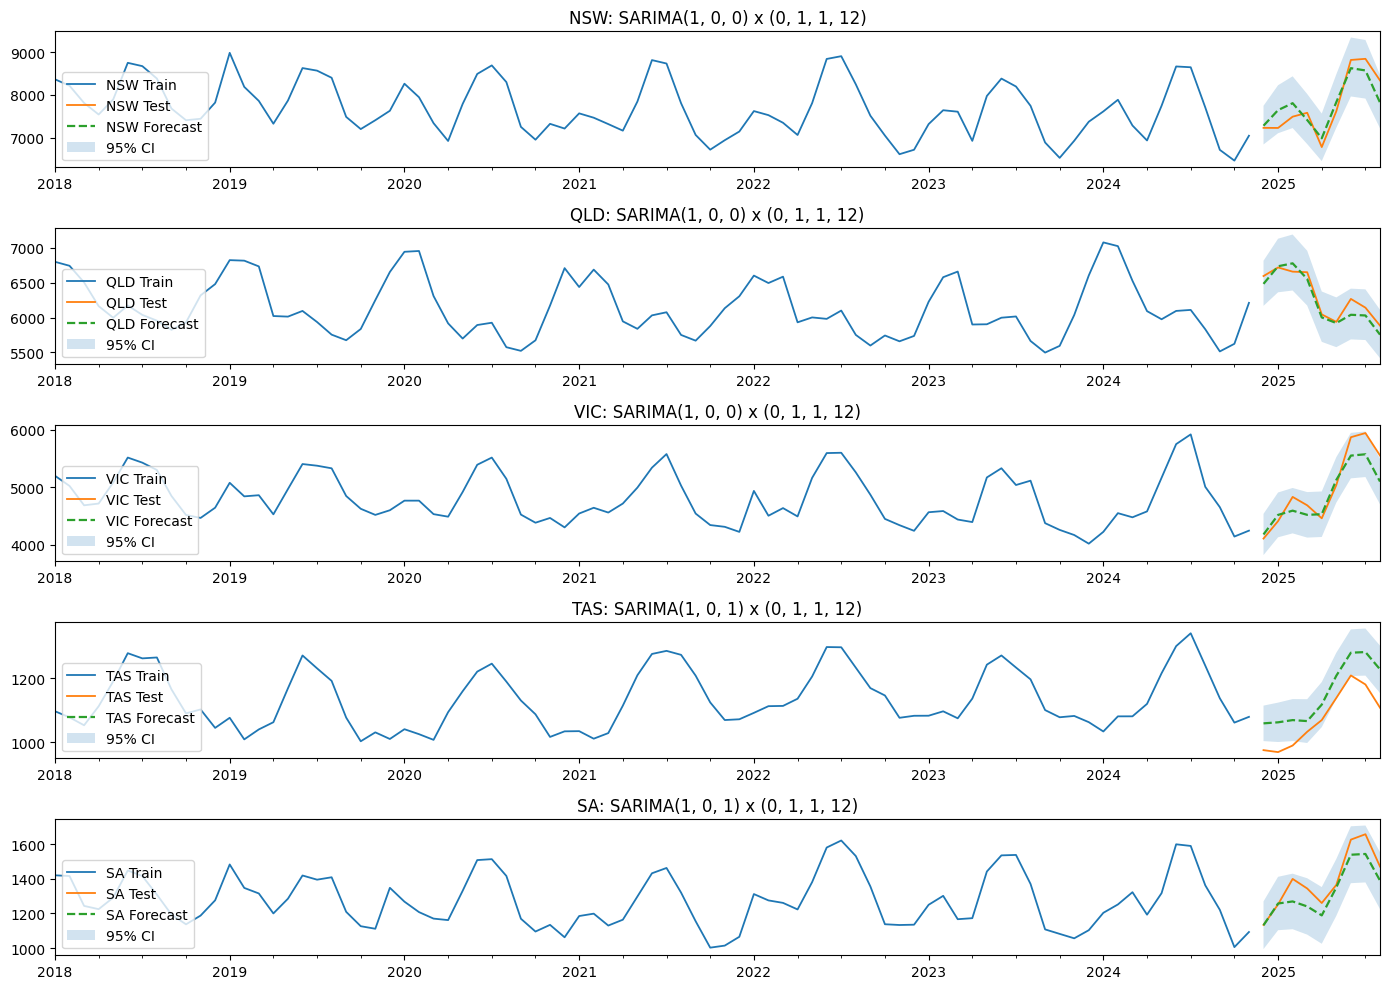

In [37]:
fig, axes = plt.subplots(5, 1, figsize=(14, 10), sharex=False)
for ax, region in zip(axes, ["NSW","QLD","VIC", "TAS", "SA"]):
    y_tr = to_series(train_dict[region])
    y_te = to_series(test_dict[region], like=best_fits[region]["fc"])
    fc   = best_fits[region]["fc"]
    ci   = best_fits[region]["ci"]

    y_tr.plot(ax=ax, label=f"{region} Train", lw=1.3)
    y_te.plot(ax=ax, label=f"{region} Test",  lw=1.3)
    fc.plot(ax=ax,   label=f"{region} Forecast", lw=1.6, ls='--')
    if isinstance(ci, pd.DataFrame) and set(['lower','upper']).issubset(ci.columns):
        ax.fill_between(fc.index, ci['lower'], ci['upper'], alpha=0.2, label="95% CI")

    ax.set_title(f"{region}: SARIMA{best_orders[region]['order']} x {best_orders[region]['seasonal']}")
    ax.legend(loc="lower left")
    ax.set_xlabel("")

plt.tight_layout()
plt.show()


NSW mean(resid)=1111.786, std=2863.309
ARCH p-value: 0.1662688120840442
LB(1..24) p-value: 5.1017663650779975e-51


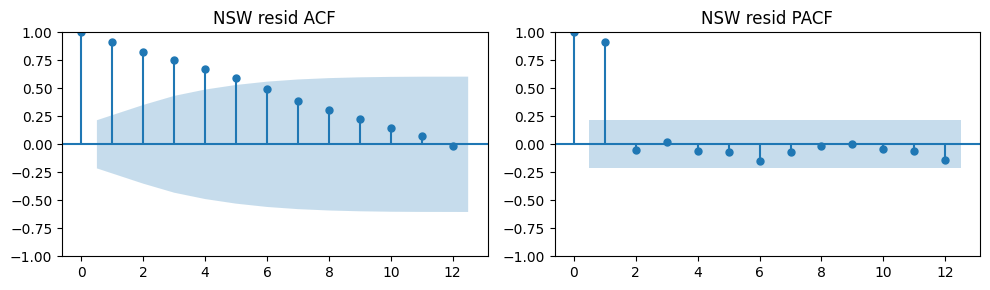


QLD mean(resid)=880.871, std=2226.485
ARCH p-value: 0.9968229216111105
LB(1..24) p-value: 4.577116940891153e-49


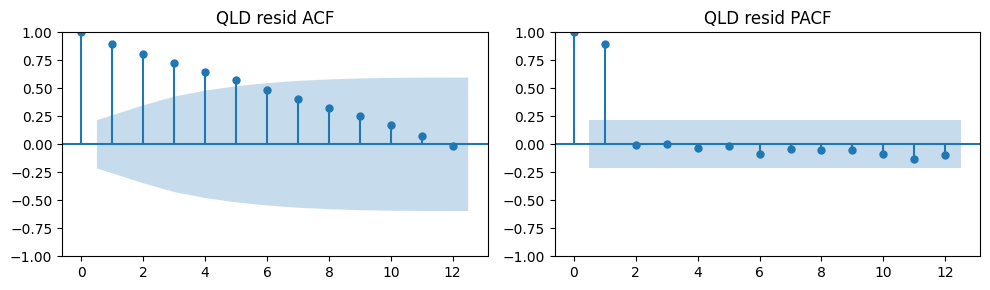


VIC mean(resid)=673.788, std=1781.647
ARCH p-value: 0.936644771397642
LB(1..24) p-value: 3.9639330081593187e-50


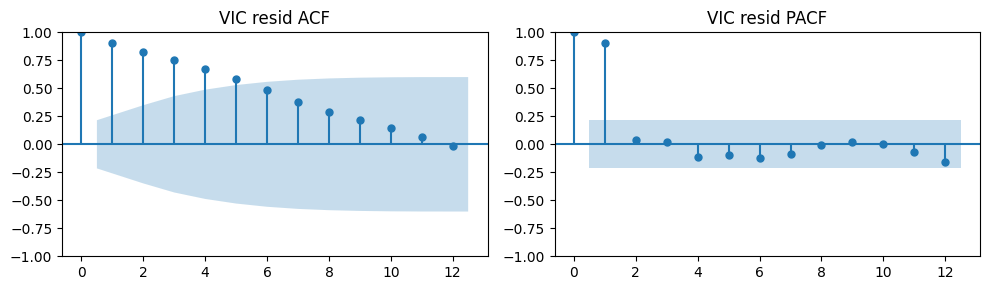


TAS mean(resid)=165.403, std=407.430
ARCH p-value: 0.24864850354276455
LB(1..24) p-value: 4.308194976631738e-50


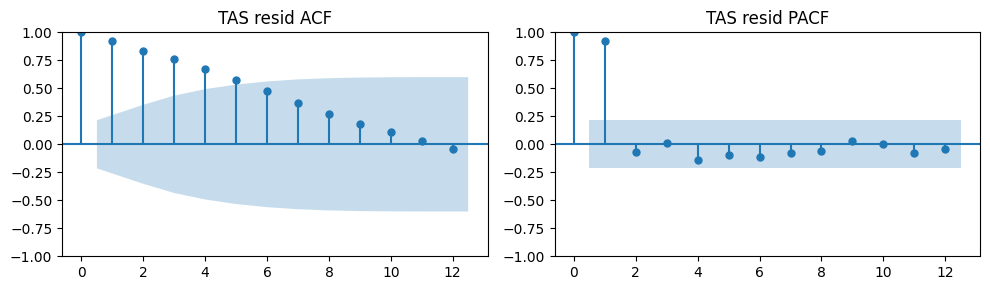


SA mean(resid)=183.588, std=467.451
ARCH p-value: 0.9941280934004089
LB(1..24) p-value: 4.132252835475223e-48


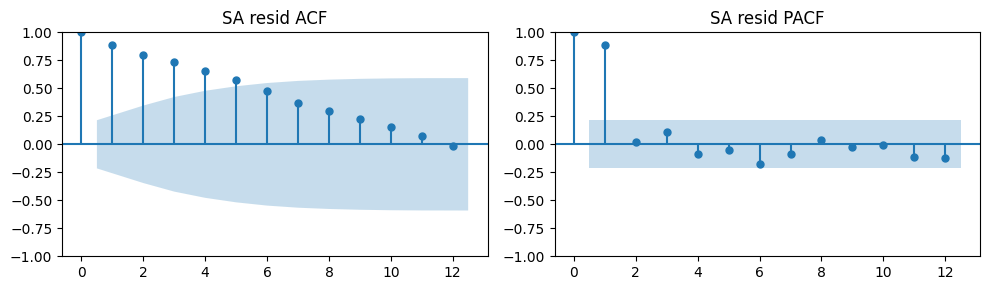

In [38]:
for r in ["NSW","QLD","VIC", 'TAS', "SA"]:
    resid = best_fits[r]["resid_orig"].dropna()
    print(f"\n{r} mean(resid)={resid.mean():.3f}, std={resid.std():.3f}")
    print("ARCH p-value:", het_arch(resid, nlags=12)[1])   # >0.05 ⇒ no strong ARCH
    print("LB(1..24) p-value:", acorr_ljungbox(resid, lags=[24], return_df=True)["lb_pvalue"].iloc[-1])

    fig, ax = plt.subplots(1,2, figsize=(10,3))
    plot_acf(resid, lags=12, ax=ax[0]); ax[0].set_title(f"{r} resid ACF")
    plot_pacf(resid, lags=12, ax=ax[1]); ax[1].set_title(f"{r} resid PACF")
    plt.tight_layout(); plt.show()


# Regression model

In [39]:
REPO = Path("/Users/linh/Documents/36103 Statistical Thinking for Data Science /Assignment 2/stds-group7")  # or wherever STDS-GROUP7 lives
WEATHER = REPO / "data" / "weather" / "avg_weather_20180101_20250911.csv"

print("Reading:", WEATHER.resolve())
weather_data = pd.read_csv(WEATHER)
weather_data.tail()

Reading: /Users/linh/Documents/36103 Statistical Thinking for Data Science /Assignment 2/stds-group7/data/weather/avg_weather_20180101_20250911.csv


state  YYYY-MM-DD  daily_rain  max_temp  min_temp  radiation  rh_tmax  \
14050   TAS  2025-09-07        1.87     15.12      4.46       5.16    57.38   
14051   TAS  2025-09-08       13.71     16.03      8.52      12.04    65.74   
14052   TAS  2025-09-09        4.97     12.48      5.16      13.01    51.53   
14053   TAS  2025-09-10        0.48     13.36      2.86      14.03    49.72   
14054   TAS  2025-09-11        0.21     14.43      4.36      13.94    50.77   

       rh_tmin  
14050    99.66  
14051    96.99  
14052    83.12  
14053    95.68  
14054    95.25

In [40]:
weather_data['rh_mean'] = (weather_data['rh_tmax'] + weather_data['rh_tmin']) / 2 #since they are highly correlated -> we make the average the feature
weather_data['mean_temp'] = (weather_data['max_temp'] + weather_data['min_temp']) / 2
weather_data.drop(columns=['max_temp', 'min_temp', 'rh_tmax', 'rh_tmin'], inplace=True) 

In [41]:
# Process weather data to monthly frequency
wd = weather_data.copy()
wd['date'] = pd.to_datetime(wd['YYYY-MM-DD'])
w_m = (wd.groupby(["state", pd.Grouper(key="date", freq="M")])
         .agg(rain=("daily_rain", "sum"),
              mean_temp=("mean_temp", "mean"),
              radiation=("radiation", "mean"),
              rh_mean=("rh_mean", "mean"))
         .reset_index()
         .rename(columns={"date": "MONTH_END"}))
w_m["ym"] = w_m["MONTH_END"].dt.to_period("M")
w_m = w_m.sort_values(["state", "ym"])

In [42]:
merged_datasets = []
datasets = [("NSW", NSW_data), ("QLD", QLD_data), ("VIC", VIC_data), ("TAS", TAS_data), ("SA", SA_data)]
wd = weather_data.copy()
wd['date'] = pd.to_datetime(wd['YYYY-MM-DD'])
w_m = (wd.groupby(["state", pd.Grouper(key="date", freq="M")])
         .agg(rain=("daily_rain", "sum"),
              mean_temp=("mean_temp", "mean"),
              radiation=("radiation", "mean"),
              rh_mean=("rh_mean", "mean"))
         .reset_index()
         .rename(columns={"date": "MONTH_END"}))
w_m["ym"] = w_m["MONTH_END"].dt.to_period("M")
w_m = w_m.sort_values(["state", "ym"])

for state, df in datasets:
    # Convert SETTLEMENTDATE to datetime
    df['SETTLEMENTDATE'] = pd.to_datetime(df['SETTLEMENTDATE'])
    df.sort_values('SETTLEMENTDATE', inplace=True)

    # Extract time-based features
    d = df['SETTLEMENTDATE']
    df['Year'] = d.dt.year
    df['Month'] = d.dt.month
    df['Quarter'] = d.dt.quarter
    df['DaysInMonth'] = d.dt.days_in_month

    # Aggregate energy data to monthly frequency
    monthly_df = df.groupby(['Year', 'Month']).agg({
        'TOTALDEMAND': 'mean',  # Avg total demand for the month
        'RRP': 'mean',         # Average RRP for the month
        'REGION': 'first',     # Keep the region (should be consistent within state)
        'Quarter': 'first',    # Take the first quarter of the month
        'DaysInMonth': 'first' # Take the days in month (consistent within month)
    }).reset_index()

    # Add holiday-related features
    years = range(int(monthly_df["Year"].min()), int(monthly_df["Year"].max()) + 1)
    hol = holidays.Australia(subdiv=state, years=years)
    hol_month = (
        pd.Series(1, index=pd.to_datetime(list(hol.keys())))
          .to_frame("is_hol")
          .assign(ym=lambda s: s.index.to_period("M"))
          .groupby("ym")["is_hol"].sum()
    )

    # Map holiday features to monthly energy data
    monthly_df["ym"] = pd.to_datetime(monthly_df[['Year', 'Month']].assign(day=1)).dt.to_period("M")
    monthly_df["HolidayCount"] = monthly_df["ym"].map(hol_month).fillna(0).astype(int)
    monthly_df["HolidayShare"] = monthly_df["HolidayCount"] / monthly_df["DaysInMonth"]

    # Calculate months since start of dataset
    monthly_df["t"] = ((monthly_df["Year"] - monthly_df["Year"].min()) * 12 + 
                       (monthly_df["Month"] - monthly_df["Month"].min()))

    # Drop temporary columns from energy data
    monthly_df.drop(columns=['DaysInMonth'], inplace=True)

    # Merge with weather data for the current state
    state_weather = w_m[w_m['state'] == state].copy()
    merged_df = monthly_df.merge(
        state_weather[['state', 'ym', 'rain', 'mean_temp', 'radiation', 'rh_mean']],
        left_on=['ym'],
        right_on=['ym'],
        how='left'
    )

    # Drop redundant columns and ensure state consistency
    merged_df['REGION'] = state  # Ensure REGION is set to the state
    merged_df.drop(columns=['ym'], inplace=True, errors='ignore')

    # Store the merged DataFrame
    merged_datasets.append((state, merged_df))

    # Print DataFrame info
    print(f'{state} information{"-"*30}')
    merged_df.info()

NSW information------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          93 non-null     int32  
 1   Month         93 non-null     int32  
 2   TOTALDEMAND   93 non-null     float64
 3   RRP           93 non-null     float64
 4   REGION        93 non-null     object 
 5   Quarter       93 non-null     int32  
 6   HolidayCount  93 non-null     int64  
 7   HolidayShare  93 non-null     float64
 8   t             93 non-null     int32  
 9   state         93 non-null     object 
 10  rain          93 non-null     float64
 11  mean_temp     93 non-null     float64
 12  radiation     93 non-null     float64
 13  rh_mean       93 non-null     float64
dtypes: float64(7), int32(4), int64(1), object(2)
memory usage: 8.8+ KB


QLD information------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          93 non-null     int32  
 1   Month         93 non-null     int32  
 2   TOTALDEMAND   93 non-null     float64
 3   RRP           93 non-null     float64
 4   REGION        93 non-null     object 
 5   Quarter       93 non-null     int32  
 6   HolidayCount  93 non-null     int64  
 7   HolidayShare  93 non-null     float64
 8   t             93 non-null     int32  
 9   state         93 non-null     object 
 10  rain          93 non-null     float64
 11  mean_temp     93 non-null     float64
 12  radiation     93 non-null     float64
 13  rh_mean       93 non-null     float64
dtypes: float64(7), int32(4), int64(1), object(2)
memory usage: 8.8+ KB
VIC information------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIn

In [43]:
drop_cols = ["TOTALDEMAND"]  # don't drop SETTLEMENTDATE since monthly_df has Year/Month instead

train_cutoff = pd.to_datetime("2024-12-31")
test_end     = pd.to_datetime("2025-09-01")

for state, region_df in merged_datasets:  # <-- use merged_datasets here
    df = region_df.copy().sort_values(["Year","Month"])
    df["date"] = pd.to_datetime(df[["Year","Month"]].assign(day=1))
    df = df.set_index("date")

    train_df = df.loc[:train_cutoff]
    test_df  = df.loc[train_cutoff+pd.Timedelta(days=1):test_end]

    globals()[f"{state}_X_tr"] = train_df.drop(columns=drop_cols, errors="ignore")
    globals()[f"{state}_y_tr"] = train_df["TOTALDEMAND"]

    globals()[f"{state}_X_te"] = test_df.drop(columns=drop_cols, errors="ignore")
    globals()[f"{state}_y_te"] = test_df["TOTALDEMAND"]

    print(f"Created {state}_X_tr, {state}_y_tr, {state}_X_te, {state}_y_te")


Created NSW_X_tr, NSW_y_tr, NSW_X_te, NSW_y_te
Created QLD_X_tr, QLD_y_tr, QLD_X_te, QLD_y_te
Created VIC_X_tr, VIC_y_tr, VIC_X_te, VIC_y_te
Created TAS_X_tr, TAS_y_tr, TAS_X_te, TAS_y_te
Created SA_X_tr, SA_y_tr, SA_X_te, SA_y_te


In [44]:
X_train_df = [("NSW", NSW_X_tr), ("QLD", QLD_X_tr), ("VIC", VIC_X_tr), ("TAS", TAS_X_tr), ("SA", SA_X_tr)]
y_train_df = [("NSW", NSW_y_tr), ("QLD", QLD_y_tr), ("VIC", VIC_y_tr), ("TAS", TAS_y_tr), ("SA", SA_y_tr)]
X_test_df  = [("NSW", NSW_X_te), ("QLD", QLD_X_te), ("VIC", VIC_X_te), ("TAS", TAS_X_te), ("SA", SA_X_te)]
y_test_df  = [("NSW", NSW_y_te), ("QLD", QLD_y_te), ("VIC", VIC_y_te), ("TAS", TAS_y_te), ("SA", SA_y_te)]

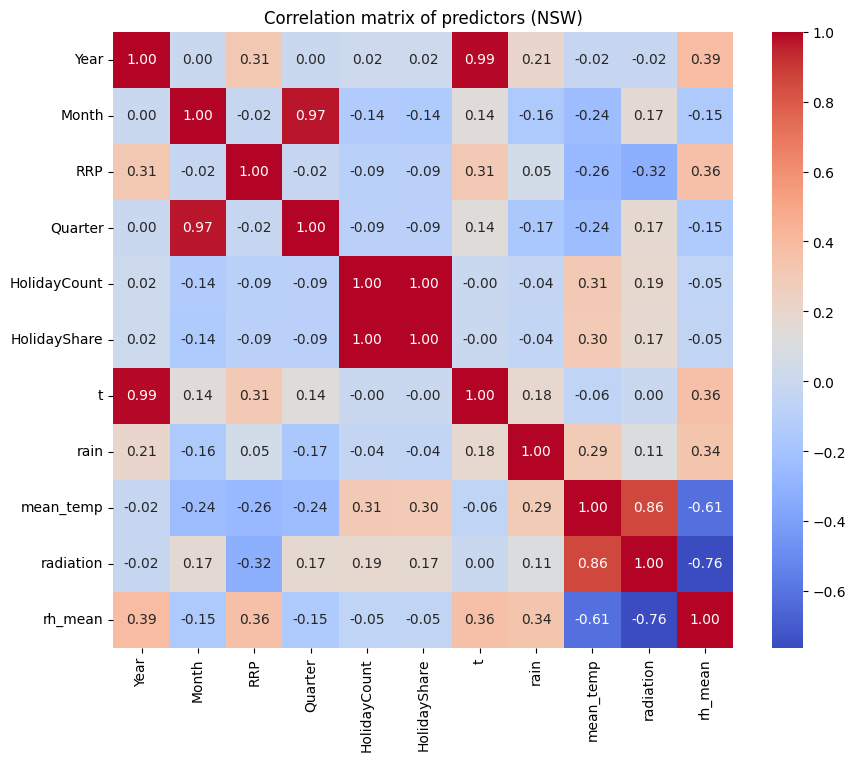

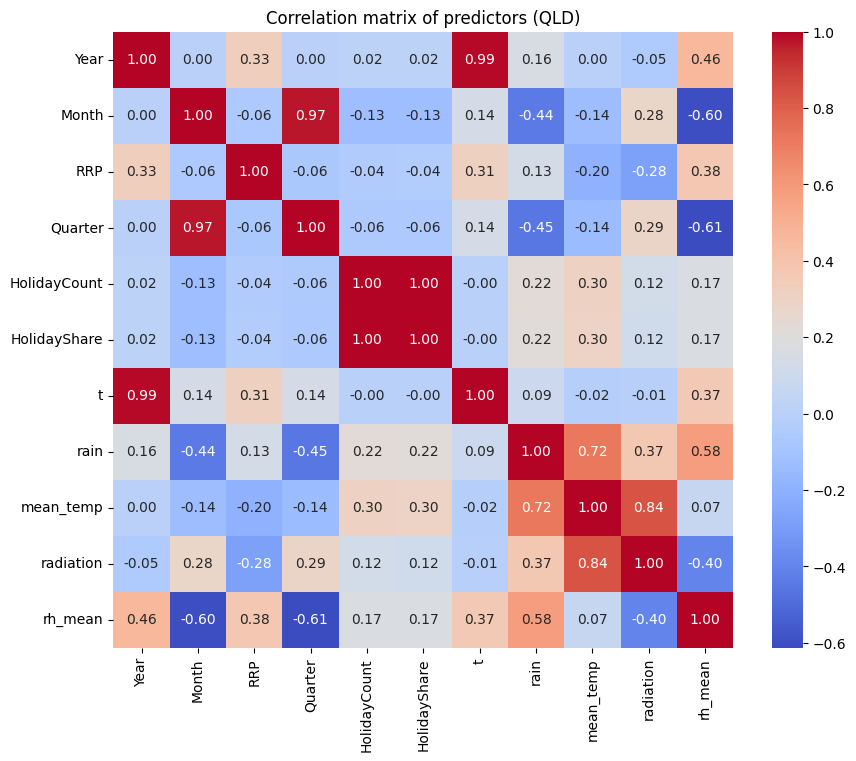

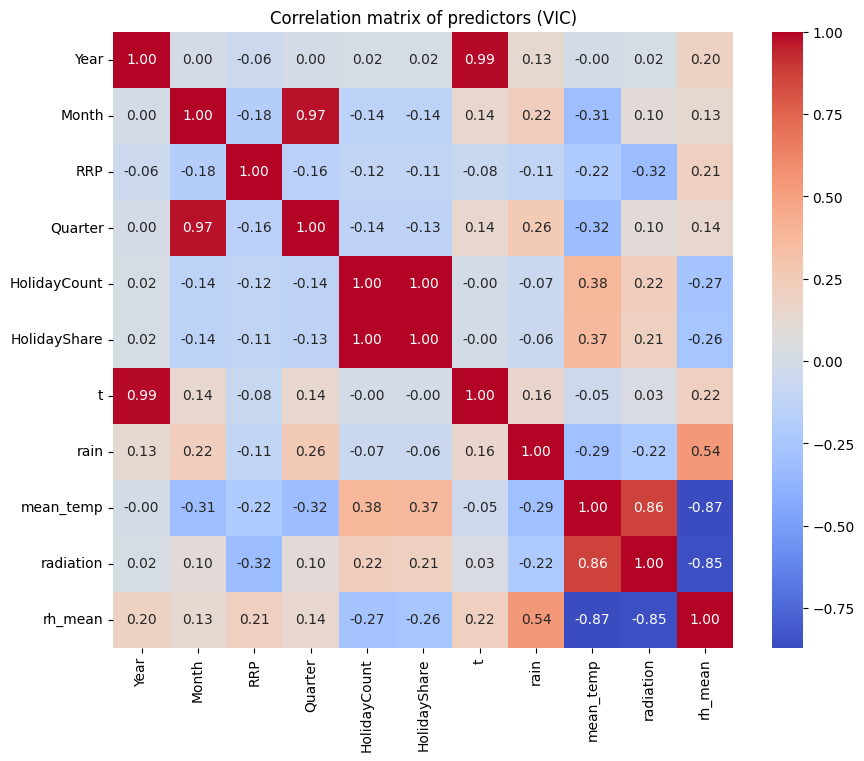

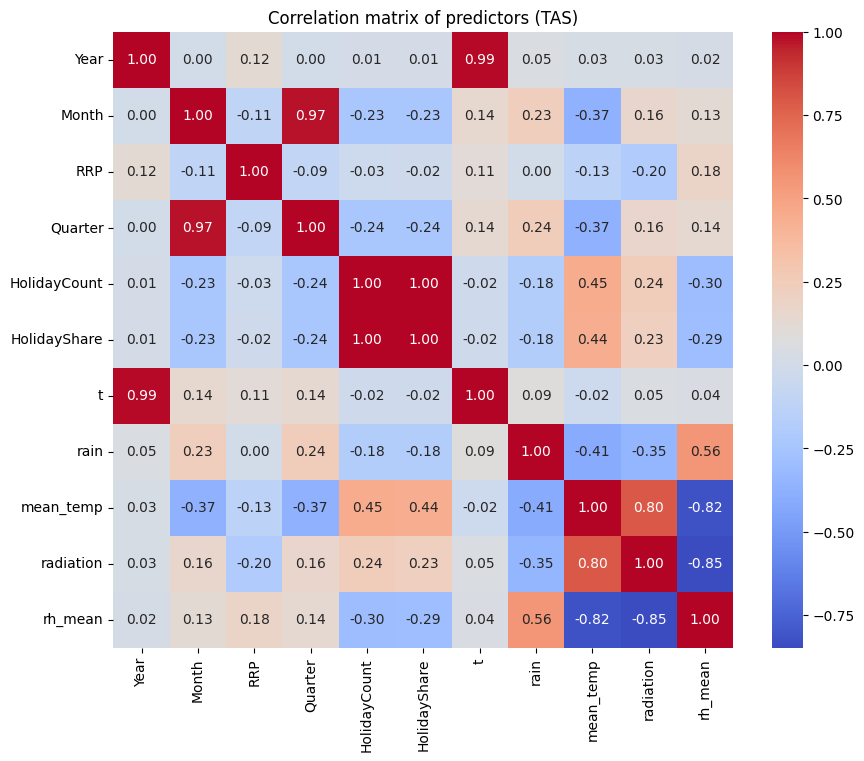

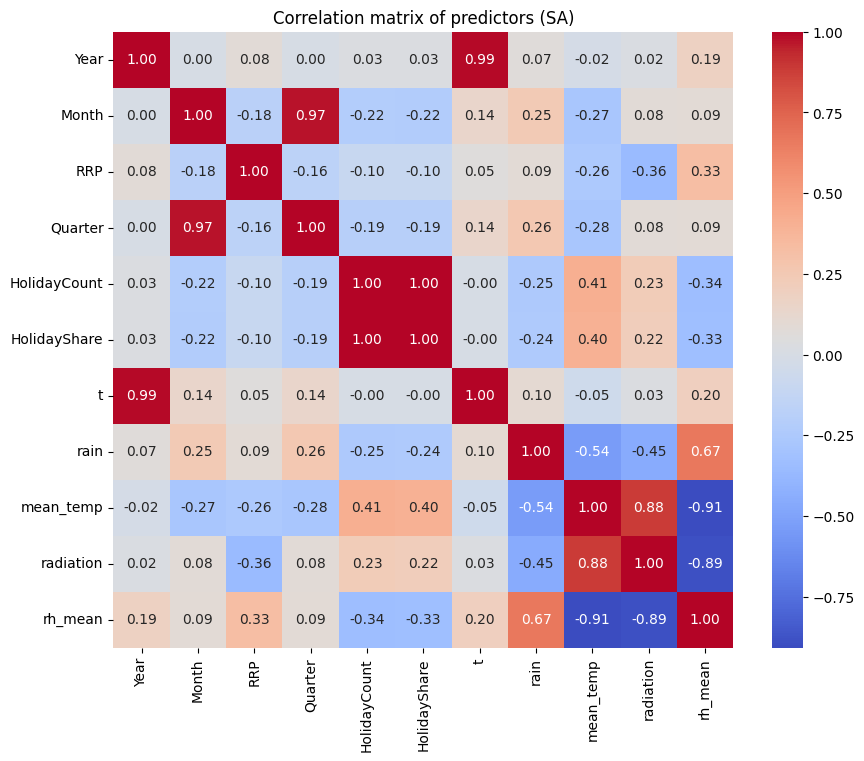

In [45]:
for name, df in X_train_df:
    X_corr = df.copy()
    X_corr = X_corr.select_dtypes(include="number")

    plt.figure(figsize=(10,8))
    sns.heatmap(X_corr.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(f"Correlation matrix of predictors ({name})")
    plt.show()


- All datasets have correlation between (Year, t), (Month, Quarter), (Mean temp, Radiation), (mean temp, rh_mean), (radiation, rh_mean)

--> Keep trend (t), Holidayshare, Month

In [46]:
def compute_vif(df, features):
    X = df[features].dropna()
    vif_data = []
    for i, col in enumerate(X.columns):
        vif = variance_inflation_factor(X.values, i)
        vif_data.append((col, vif))
    return pd.DataFrame(vif_data, columns=["feature", "VIF"])

In [47]:
datasets = {state: df for state, df in merged_datasets}

num_features = [
    "RRP","HolidayShare","t", 'HolidayCount',
    "rain","mean_temp","radiation","rh_mean"]

for name, dataset in datasets.items(): 
    vif_df = compute_vif(dataset, num_features)
    print(f"\n{name} VIFs:")
    print(vif_df.sort_values("VIF", ascending=False))



NSW VIFs:
        feature          VIF
3  HolidayCount  6497.000769
1  HolidayShare  6459.476483
5     mean_temp    60.264462
6     radiation    57.651695
7       rh_mean    21.287689
4          rain     5.471236
2             t     4.728541
0           RRP     4.367482

QLD VIFs:
        feature          VIF
3  HolidayCount  5622.503465
1  HolidayShare  5591.085289
5     mean_temp   524.623325
6     radiation   247.436862
7       rh_mean    81.818563
4          rain     8.809107
2             t     4.971981
0           RRP     4.135558

VIC VIFs:
        feature          VIF
3  HolidayCount  5937.818815
1  HolidayShare  5886.770368
5     mean_temp    49.930866
6     radiation    35.729999
7       rh_mean    28.708107
4          rain     6.926195
2             t     4.085049
0           RRP     3.578233

TAS VIFs:
        feature          VIF
3  HolidayCount  6180.359172
1  HolidayShare  6132.957440
5     mean_temp    55.422336
7       rh_mean    41.228517
6     radiation    22.396153

**Dropping variables**
- Year
- Holiday count
- Quarter
- rh_mean, mean_temp, radiation: Use PCA to reduce correlation

In [48]:
drop_cols = ['Year', 'Quarter', 'HolidayCount']

X_train_drop, X_test_drop = [], []

for (name, X_tr), (_, X_te) in zip(X_train_df, X_test_df):
    X_tr = X_tr.drop(columns=[c for c in drop_cols if c in X_tr.columns], errors="ignore")
    X_te = X_te.drop(columns=[c for c in drop_cols if c in X_te.columns], errors="ignore")
    
    X_train_drop.append((name, X_tr))
    X_test_drop.append((name, X_te))

X_train_df = X_train_drop
X_test_df  = X_test_drop

In [49]:
weather_cols = ['mean_temp', 'radiation', 'rh_mean']
X_train_proc, X_test_proc = [], []

for (name, X_tr), (_, X_te) in zip(X_train_df, X_test_df):
    available_weather = [c for c in weather_cols if c in X_tr.columns]
    if len(available_weather) > 1:
        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr[available_weather].fillna(0))

        pca = PCA(n_components=1, random_state=42)
        pcs_train = pca.fit_transform(X_tr_scaled)

        # Apply same transformation to test
        X_te_scaled = scaler.transform(X_te[available_weather].fillna(0))
        pcs_test = pca.transform(X_te_scaled)

        for i in range(1):
            X_tr[f"weather_PC{i+1}"] = pcs_train[:, i]
            X_te[f"weather_PC{i+1}"] = pcs_test[:, i]

        # Drop original weather cols
        X_tr = X_tr.drop(columns=available_weather)
        X_te = X_te.drop(columns=available_weather)

        print(f"{name}: explained variance by {1} PC(s) = {pca.explained_variance_ratio_.sum():.2%}")

    X_train_proc.append((name, X_tr))
    X_test_proc.append((name, X_te))

# Now you have updated lists like your original
X_train_df = X_train_proc
X_test_df  = X_test_proc

NSW: explained variance by 1 PC(s) = 83.01%
QLD: explained variance by 1 PC(s) = 63.40%
VIC: explained variance by 1 PC(s) = 90.73%
TAS: explained variance by 1 PC(s) = 88.13%
SA: explained variance by 1 PC(s) = 92.84%


In [50]:
num_features = ["RRP","HolidayShare","t","rain", 'weather_PC1']
for name, X_tr in X_train_df: 
    vif_df = compute_vif(X_tr, num_features)
    print(f"\n{name} VIFs:")
    print(vif_df.sort_values("VIF", ascending=False))



NSW VIFs:
        feature       VIF
2             t  3.870913
0           RRP  3.335744
3          rain  2.907972
1  HolidayShare  1.430870
4   weather_PC1  1.157374

QLD VIFs:
        feature       VIF
0           RRP  3.612992
2             t  3.208159
3          rain  3.086977
1  HolidayShare  1.578442
4   weather_PC1  1.450918

VIC VIFs:
        feature       VIF
3          rain  3.756121
2             t  3.308330
0           RRP  2.211932
1  HolidayShare  1.767574
4   weather_PC1  1.236903

TAS VIFs:
        feature       VIF
3          rain  3.712388
2             t  3.440585
0           RRP  2.651323
1  HolidayShare  1.692226
4   weather_PC1  1.334981

SA VIFs:
        feature       VIF
2             t  3.095616
3          rain  3.029043
0           RRP  2.418299
1  HolidayShare  1.675184
4   weather_PC1  1.482487


**No multicollinearity (all VIF < 5)**

## OLS

In [51]:
def eval_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

def run_ols(train_df, test_df, y_col="TOTALDEMAND"):
    """
    Run OLS with Month categorical.
    """
    base = ["RRP", "HolidayShare", "t", "rain", "weather_PC1"]

    formula = f"{y_col} ~ " + " + ".join(base) + " + C(Month)"
    model = smf.ols(formula=formula, data=train_df).fit()

    pred = model.predict(test_df)

    rmse, mae = eval_metrics(test_df[y_col], pred)
    r2 = model.rsquared
    return model, pred, rmse, mae, r2

In [52]:
models_month   = {}
preds_month    = {}
results = []

for (region, X_tr), (_, y_tr), (_, X_te), (_, y_te) in zip(X_train_df, y_train_df, X_test_df, y_test_df):
    train_df = X_tr.copy()
    train_df["TOTALDEMAND"] = y_tr

    test_df = X_te.copy()
    test_df["TOTALDEMAND"] = y_te

    m_month, pred_month, rmse_m, mae_m, r2_m = run_ols(train_df, test_df)
    models_month[region] = m_month
    preds_month[region]  = (y_te, pred_month)

    results.append({
        "Region": region,
        "RMSE": rmse_m,
        "MAE": mae_m,
        "R2":  r2_m
    })

results_df = pd.DataFrame(results)
results_df

Region        RMSE         MAE        R2
0    NSW  507.696338  397.410599  0.923376
1    QLD  193.525970  160.532357  0.870623
2    VIC  391.692839  327.163521  0.910865
3    TAS   99.138899   93.411268  0.887271
4     SA  159.764046  115.132345  0.884205

Not very good at all -> very high RMSE,MAE and super low R2

==> A way to make it better is to add lag. Since demand at a given time is highly dependent on its own recent history, so including lag terms provides the model with “memory” of past consumption. 

## OLS with lags

In [53]:
def add_lags_full(X, y, lags=[1,2,3], cutoff=None):
    df = X.copy()
    for l in lags:
        df[f"lag_{l}"] = y.shift(l)
    df = df.dropna()
    y_new = y.loc[df.index]

    if cutoff is not None:
        train_mask = df.index <= cutoff
        X_tr, y_tr = df.loc[train_mask], y_new.loc[train_mask]
        X_te, y_te = df.loc[~train_mask], y_new.loc[~train_mask]
        return X_tr, y_tr, X_te, y_te

    return df, y_new


In [54]:
X_train_lags, y_train_lags = [], []
X_test_lags,  y_test_lags  = [], []

for (region, X_tr), (_, y_tr), (_, X_te), (_, y_te) in zip(X_train_df, y_train_df, X_test_df, y_test_df):
    X_full = pd.concat([X_tr, X_te])
    y_full = pd.concat([y_tr, y_te])

    X_tr_lag, y_tr_lag, X_te_lag, y_te_lag = add_lags_full(X_full, y_full, lags=[1,2,3], cutoff=y_tr.index.max())

    X_train_lags.append((region, X_tr_lag))
    y_train_lags.append((region, y_tr_lag))
    X_test_lags.append((region, X_te_lag))
    y_test_lags.append((region, y_te_lag))


In [55]:
def run_ols(train_df, test_df, y_col='TOTALDEMAND', use_lags=False):
    base = ["RRP", "HolidayShare", "t", "rain", "weather_PC1"]
    features = base + ["C(Month)"]

    if use_lags:
        for lag in [1,2,3]:
            lag_col = f"lag_{lag}"
            if lag_col in train_df.columns:
                features.append(lag_col)

    formula = f'{y_col} ~ ' + ' + '.join(features)
    model = smf.ols(formula=formula, data=train_df).fit()
    pred = model.predict(test_df)
    rmse, mae = eval_metrics(test_df[y_col], pred)
    r2 = model.rsquared
    return model, pred, rmse, mae, r2


In [56]:
results = []

for (region, X_tr), (_, y_tr), (_, X_te), (_, y_te) in zip(X_train_lags, y_train_lags, X_test_lags, y_test_lags):
    train_df = X_tr.copy(); train_df["TOTALDEMAND"] = y_tr
    test_df  = X_te.copy(); test_df["TOTALDEMAND"]  = y_te

    m, pred, rmse, mae, r2 = run_ols(train_df, test_df, use_lags=True)

    results.append({"Region": region, "RMSE": rmse, "MAE": mae, "R2": r2})

results_df = pd.DataFrame(results).set_index("Region")
results_df

RMSE         MAE        R2
Region                                  
NSW     440.117611  392.516778  0.937410
QLD     140.176530  117.496747  0.905094
VIC     330.388742  282.921833  0.921288
TAS      44.394411   40.452125  0.928479
SA      143.199128   91.482238  0.908196

In [57]:
from sklearn.metrics import r2_score

def run_ols(train_df, test_df, y_col="TOTALDEMAND", lag_list=None, use_month=True):
    base = ["RRP", "HolidayShare", "t", "rain", "weather_PC1"]
    features = base.copy()
    if use_month and "Month" in train_df.columns:
        features.append("C(Month)")

    if lag_list is None:
        lag_list = []

    for lag in lag_list:
        lag_col = f"lag_{lag}"
        if lag_col in train_df.columns:
            features.append(lag_col)

    formula = f"{y_col} ~ " + " + ".join(features)
    model = smf.ols(formula=formula, data=train_df).fit()

    pred = model.predict(test_df)
    df_eval = pd.DataFrame({"y_true": test_df[y_col], "y_pred": pred}).dropna()

    if df_eval.empty:
        print("⚠️ Warning: No valid rows left for evaluation.")
        return model, [], [], np.nan, np.nan, np.nan

    rmse, mae = eval_metrics(df_eval["y_true"], df_eval["y_pred"])
    r2 = model.rsquared

    return model, df_eval["y_true"], df_eval["y_pred"], rmse, mae, r2


In [58]:
lag_strategies = {
    "Lag1": [1],
    "Lag2": [2],
    "Lag3": [3],
    "Lag1,2": [1, 2],       
    "Lag1,2,3": [1, 2, 3],
    "Lag12": [12]
}

results = []
fitted_models = {}

for name, lags in lag_strategies.items():
    for (region, X_tr), (_, y_tr), (_, X_te), (_, y_te) in zip(X_train_df, y_train_df, X_test_df, y_test_df):
        
        train_df = X_tr.copy(); train_df["TOTALDEMAND"] = y_tr
        test_df  = X_te.copy(); test_df["TOTALDEMAND"]  = y_te

        m, y_true, y_pred, rmse, mae, r2 = run_ols(train_df, test_df, lag_list=lags, use_month=True)

        # store the model by region and lag spec
        fitted_models[(region, name)] = m

        results.append({
            "Lag_Spec": name,
            "Region": region,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2
        })

results_df = pd.DataFrame(results)

In [59]:
results_df

Lag_Spec Region        RMSE         MAE        R2
0       Lag1    NSW  507.696338  397.410599  0.923376
1       Lag1    QLD  193.525970  160.532357  0.870623
2       Lag1    VIC  391.692839  327.163521  0.910865
3       Lag1    TAS   99.138899   93.411268  0.887271
4       Lag1     SA  159.764046  115.132345  0.884205
5       Lag2    NSW  507.696338  397.410599  0.923376
6       Lag2    QLD  193.525970  160.532357  0.870623
7       Lag2    VIC  391.692839  327.163521  0.910865
8       Lag2    TAS   99.138899   93.411268  0.887271
9       Lag2     SA  159.764046  115.132345  0.884205
10      Lag3    NSW  507.696338  397.410599  0.923376
11      Lag3    QLD  193.525970  160.532357  0.870623
12      Lag3    VIC  391.692839  327.163521  0.910865
13      Lag3    TAS   99.138899   93.411268  0.887271
14      Lag3     SA  159.764046  115.132345  0.884205
15    Lag1,2    NSW  507.696338  397.410599  0.923376
16    Lag1,2    QLD  193.525970  160.532357  0.870623
17    Lag1,2    VIC  391.692839  327.163521  0.910865
18    Lag1,2    TAS   99.138899   93.411268  0.887271
19    Lag1,2     SA  159.764046  115.132345  0.884205
20  Lag1,2,3    NSW  507.696338  397.410599  0.923376
21  Lag1,2,3    QLD  193.525970  160.532357  0.870623
22  Lag1,2,3    VIC  391.692839  327.163521  0.910865
23  Lag1,2,3    TAS   99.138899   93.411268  0.887271
24  Lag1,2,3     SA  159.764046  115.132345  0.884205
25     Lag12    NSW  507.696338  397.410599  0.923376
26     Lag12    QLD  193.525970  160.532357  0.870623
27     Lag12    VIC  391.692839  327.163521  0.910865
28     Lag12    TAS   99.138899   93.411268  0.887271
29     Lag12     SA  159.764046  115.132345  0.884205

Model with lag 1 and lag1+2+3 have the best RMSE, MAE and R2

- Lag 1: last month's demand directly predicts this month's demand 

- Lag 1+2+3: This month’s demand is explained by a combination of the last three months’ (the quarter) demands, not just the immediately previous month

In [60]:
# Does having Month as category variable helps with lagged models?
strategies = {
    "MonthOnly": {"lags": None, "month": True},
    "LagsOnly":  {"lags": [1,2,3], "month": False},
    "Both":      {"lags": [1,2,3], "month": True}
}

results = []
for strat, cfg in strategies.items():
    total_se = 0.0
    total_ae = 0.0
    total_n  = 0

    for (region, X_tr), (_, y_tr), (_, X_te), (_, y_te) in zip(
        X_train_df, y_train_df, X_test_df, y_test_df
    ):
        train_df = X_tr.copy(); train_df["TOTALDEMAND"] = y_tr
        test_df  = X_te.copy(); test_df["TOTALDEMAND"]  = y_te

        m, y_true, y_pred, rmse, mae, r2 = run_ols(
            train_df, test_df,
            lag_list=cfg["lags"],
            use_month=cfg["month"]
        )

        n_obs = len(y_true)
        total_se += np.sum((y_true - y_pred) ** 2)
        total_ae += np.sum(np.abs(y_true - y_pred))
        total_n  += n_obs

        results.append({
            "Spec": strat,
            "Region": region,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2
        })

    # pooled weighted
    pooled_rmse = np.sqrt(total_se / total_n)
    pooled_mae  = total_ae / total_n
    results.append({
        "Spec": strat,
        "Region": "Overall (weighted)",
        "RMSE": pooled_rmse,
        "MAE": pooled_mae,
        "R2": np.nan
    })

results_df = pd.DataFrame(results)
results_df.pivot(index="Region", columns="Spec", values=["RMSE","MAE","R2"])

RMSE                                 MAE  \
Spec                      Both    LagsOnly   MonthOnly        Both   
Region                                                               
NSW                 507.696338  738.956087  507.696338  397.410599   
Overall (weighted)  311.121913  431.887241  311.121913  218.730018   
QLD                 193.525970  309.623248  193.525970  160.532357   
SA                  159.764046  190.014813  159.764046  115.132345   
TAS                  99.138899   95.320211   99.138899   93.411268   
VIC                 391.692839  495.498453  391.692839  327.163521   

                                                  R2                      
Spec                  LagsOnly   MonthOnly      Both  LagsOnly MonthOnly  
Region                                                                    
NSW                 624.374215  397.410599  0.923376  0.465411  0.923376  
Overall (weighted)  312.645864  218.730018       NaN       NaN       NaN  
QLD                 262.078809  160.532357  0.870623  0.637789  0.870623  
SA                  174.660777  115.132345  0.884205  0.569931  0.884205  
TAS                  89.174447   93.411268  0.887271  0.772401  0.887271  
VIC                 412.941071  327.163521  0.910865  0.703836  0.910865

Since C(month) does not add any explanability and it makes the model even more complex --> monthly seasonality is already captured by autoregressive lag

==> So the final model will be "TOTALDEMAND ~ RRP + HolidayShare + t + rain + weather_PC1 + lag1 + lag2 + lag3"

In [61]:
fitted_models = {}

for (region, X_tr), (_, y_tr) in zip(X_train_df, y_train_df):
    df_tr = X_tr.copy()
    df_tr["TOTALDEMAND"] = y_tr

    # Adding lag1,2,3 as per previous analysis
    df_tr["lag1"] = df_tr["TOTALDEMAND"].shift(1)
    df_tr["lag2"] = df_tr["TOTALDEMAND"].shift(2)
    df_tr["lag3"] = df_tr["TOTALDEMAND"].shift(3)
    df_tr = df_tr.dropna()

    # standardise to plot coefficients
    features_to_scale = ["RRP", "HolidayShare", "t", "rain", "weather_PC1", "lag1", "lag2", "lag3"]
    scaler = StandardScaler()
    df_tr[features_to_scale] = scaler.fit_transform(df_tr[features_to_scale])

    formula = "TOTALDEMAND ~ RRP + HolidayShare + t + rain + weather_PC1 + lag1 + lag2 + lag3"
    model = smf.ols(formula=formula, data=df_tr).fit()

    fitted_models[region] = {"model": model, "scaler": scaler}

    print(f"--- {region} ---")
    print(model.summary())
    print()


--- NSW ---
                            OLS Regression Results                            
Dep. Variable:            TOTALDEMAND   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     55.00
Date:                Wed, 17 Sep 2025   Prob (F-statistic):           1.25e-27
Time:                        01:41:53   Log-Likelihood:                -558.32
No. Observations:                  81   AIC:                             1135.
Df Residuals:                      72   BIC:                             1156.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     7667.4808     28.093  

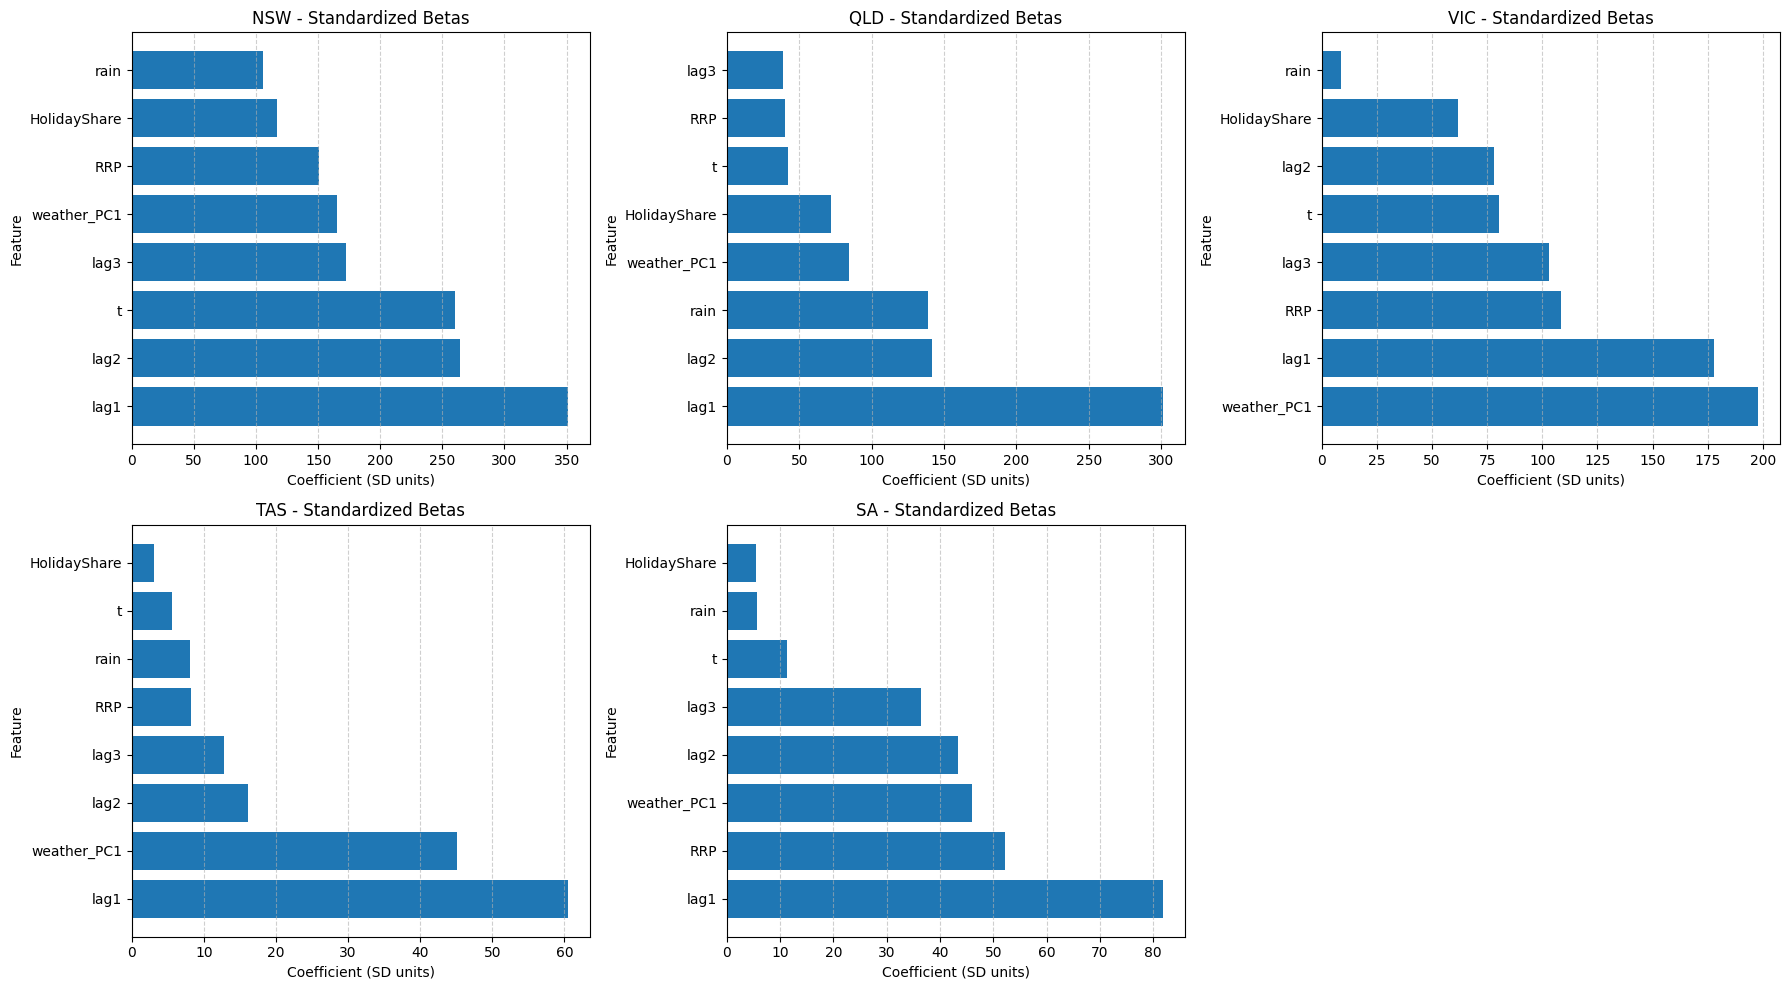

In [62]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

regions = list(fitted_models.keys())

for i, region in enumerate(regions):
    model = fitted_models[region]["model"]

    # Collect coefficients
    coefs = pd.DataFrame({
        "feature": model.params.index,
        "coef": np.abs(model.params.values)
    })
    coefs = coefs[coefs["feature"] != "Intercept"]

    # Sort by absolute value
    coefs = coefs.sort_values("coef", key=lambda x: abs(x), ascending=True)

    # Horizontal bar plot
    ax = axes[i]
    ax.barh(coefs["feature"], coefs["coef"])
    ax.set_title(f"{region} - Standardized Betas")
    ax.set_xlabel("Coefficient (SD units)")
    ax.set_ylabel("Feature")
    ax.grid(axis="x", linestyle="--", alpha=0.6)
    ax.invert_yaxis()

# Hide unused subplot(s) if fewer than 6 regions
for j in range(len(regions), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


- NSW, VIC: Demand depends on last month’s usage, plus weather, holidays, and a clear upward trend.

- QLD: Similar to NSW/VIC, but weather/holiday effects are smaller.

- TAS, SA: Demand is mostly explained by last month’s demand — weather, holidays, and price barely matter.


### Final model (all dataset combined)

In [63]:
NSW_data.head()

REGION      SETTLEMENTDATE  TOTALDEMAND    RRP PERIODTYPE  Year  Month  \
0   NSW1 2018-01-01 00:30:00      6912.25  91.86      TRADE  2018      1   
1   NSW1 2018-01-01 01:00:00      6745.63  88.83      TRADE  2018      1   
2   NSW1 2018-01-01 01:30:00      6466.06  73.62      TRADE  2018      1   
3   NSW1 2018-01-01 02:00:00      6279.80  71.49      TRADE  2018      1   
4   NSW1 2018-01-01 02:30:00      6177.31  69.27      TRADE  2018      1   

   Quarter  DaysInMonth  
0        1           31  
1        1           31  
2        1           31  
3        1           31  
4        1           31

In [64]:
df_all = pd.concat([df for _, df in merged_datasets], ignore_index=True)
df_all["date"] = pd.to_datetime(df_all[["Year","Month"]].assign(day=1))
df_all.head()

Year  Month  TOTALDEMAND        RRP REGION  Quarter  HolidayCount  \
0  2018      1  8365.807357  76.028144    NSW        1             2   
1  2018      2  8216.016957  72.795342    NSW        1             0   
2  2018      3  7813.076559  66.701351    NSW        1             2   
3  2018      4  7544.269535  75.138708    NSW        2             3   
4  2018      5  7896.182534  77.266821    NSW        2             0   

   HolidayShare  t state   rain  mean_temp  radiation    rh_mean       date  
0      0.064516  0   NSW  48.08  24.443548  24.767742  60.374355 2018-01-01  
1      0.000000  1   NSW  67.17  22.859643  21.632500  62.022321 2018-02-01  
2      0.064516  2   NSW  59.05  21.110806  18.177419  65.336290 2018-03-01  
3      0.100000  3   NSW  27.77  18.971833  14.829333  66.325167 2018-04-01  
4      0.000000  4   NSW  23.24  12.716774  11.416129  69.951452 2018-05-01

In [65]:
df_monthly = (
    df_all.groupby(["REGION", pd.Grouper(key="date", freq="M")])
    .agg({
        "TOTALDEMAND": "mean",
        "RRP": "mean",
        "HolidayShare": "mean",
        "rain": "mean",
        "mean_temp": "mean",
        "radiation": "mean",
        "rh_mean": "mean"
    })
    .reset_index()
)
df_monthly.head()

REGION       date  TOTALDEMAND        RRP  HolidayShare   rain  mean_temp  \
0    NSW 2018-01-31  8365.807357  76.028144      0.064516  48.08  24.443548   
1    NSW 2018-02-28  8216.016957  72.795342      0.000000  67.17  22.859643   
2    NSW 2018-03-31  7813.076559  66.701351      0.064516  59.05  21.110806   
3    NSW 2018-04-30  7544.269535  75.138708      0.100000  27.77  18.971833   
4    NSW 2018-05-31  7896.182534  77.266821      0.000000  23.24  12.716774   

   radiation    rh_mean  
0  24.767742  60.374355  
1  21.632500  62.022321  
2  18.177419  65.336290  
3  14.829333  66.325167  
4  11.416129  69.951452

In [66]:
df_monthly["Month"] = df_monthly["date"].dt.month
df_monthly["weather_PC1"] = (
    df_monthly[["mean_temp", "radiation", "rh_mean"]].mean(axis=1))

# adding lags
for lag in [1, 2, 3]:
    df_monthly[f"lag{lag}"] = (
        df_monthly.groupby("REGION")["TOTALDEMAND"].shift(lag))

df_monthly = df_monthly.dropna()
df_monthly.info()

<class 'pandas.core.frame.DataFrame'>
Index: 450 entries, 3 to 464
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   REGION        450 non-null    object        
 1   date          450 non-null    datetime64[ns]
 2   TOTALDEMAND   450 non-null    float64       
 3   RRP           450 non-null    float64       
 4   HolidayShare  450 non-null    float64       
 5   rain          450 non-null    float64       
 6   mean_temp     450 non-null    float64       
 7   radiation     450 non-null    float64       
 8   rh_mean       450 non-null    float64       
 9   Month         450 non-null    int32         
 10  weather_PC1   450 non-null    float64       
 11  lag1          450 non-null    float64       
 12  lag2          450 non-null    float64       
 13  lag3          450 non-null    float64       
dtypes: datetime64[ns](1), float64(11), int32(1), object(1)
memory usage: 51.0+ KB


In [67]:
cutoff = pd.to_datetime("2025-01-01")

train_df = df_monthly[df_monthly["date"] < cutoff].copy()
test_df  = df_monthly[df_monthly["date"] >= cutoff].copy()

train_df = train_df.set_index("date").sort_index()
test_df  = test_df.set_index("date").sort_index()

train_df.head()


REGION  TOTALDEMAND        RRP  HolidayShare   rain  mean_temp  \
date                                                                        
2018-04-30    NSW  7544.269535  75.138708      0.100000  27.77  18.971833   
2018-04-30    VIC  4713.905375  74.093736      0.100000  21.90  15.999833   
2018-04-30    QLD  6163.053604  63.719639      0.100000  36.39  23.906833   
2018-04-30     SA  1224.939826  98.453847      0.066667  14.96  19.483833   
2018-04-30    TAS  1112.465583  80.705236      0.066667  31.79  13.430500   

            radiation    rh_mean  Month  weather_PC1         lag1  \
date                                                                
2018-04-30  14.829333  66.325167      4    33.375444  7813.076559   
2018-04-30  12.128000  68.969000      4    32.365611  4683.384335   
2018-04-30  18.369667  68.690000      4    36.988833  6502.603972   
2018-04-30  14.763000  61.010667      4    31.752500  1243.837325   
2018-04-30   9.812667  74.210333      4    32.484500  1052.710397   

                   lag2         lag3  
date                                  
2018-04-30  8216.016957  8365.807357  
2018-04-30  5020.745737  5197.768480  
2018-04-30  6740.558921  6797.728514  
2018-04-30  1416.999591  1421.040303  
2018-04-30  1077.480409  1096.863652

In [68]:
from sklearn.preprocessing import StandardScaler

# Scale X and y separately
X_cols = ["RRP", "HolidayShare", "rain", "weather_PC1", "lag1", "lag2", "lag3"]

scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit on training data only
train_df[X_cols] = scaler_X.fit_transform(train_df[X_cols])
train_df["TOTALDEMAND"] = scaler_y.fit_transform(train_df[["TOTALDEMAND"]])

# Apply same transform to test
test_df[X_cols] = scaler_X.transform(test_df[X_cols])
test_df["TOTALDEMAND"] = scaler_y.transform(test_df[["TOTALDEMAND"]])


In [69]:
formula = "TOTALDEMAND ~ RRP + HolidayShare + rain + weather_PC1 + lag1 + lag2 + lag3 + C(REGION)"
pooled_model_std = smf.ols(formula=formula, data=train_df).fit()

print(pooled_model_std.summary())

                            OLS Regression Results                            
Dep. Variable:            TOTALDEMAND   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     4970.
Date:                Wed, 17 Sep 2025   Prob (F-statistic):               0.00
Time:                        01:41:53   Log-Likelihood:                 426.19
No. Observations:                 405   AIC:                            -828.4
Df Residuals:                     393   BIC:                            -780.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.8441      0.058  

In [70]:
# Predictions on train/test
y_train_pred = pooled_model_std.predict(train_df)
y_test_pred  = pooled_model_std.predict(test_df)

# Inverse-transform to original scale
y_train_true = scaler_y.inverse_transform(train_df[["TOTALDEMAND"]]).ravel()
y_test_true  = scaler_y.inverse_transform(test_df[["TOTALDEMAND"]]).ravel()
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.values.reshape(-1,1)).ravel()
y_test_pred_orig  = scaler_y.inverse_transform(y_test_pred.values.reshape(-1,1)).ravel()

# Wrap back into Series with the right index
y_train_true = pd.Series(y_train_true, index=train_df.index, name="y_true")
y_test_true  = pd.Series(y_test_true,  index=test_df.index,  name="y_true")
y_train_pred_orig = pd.Series(y_train_pred_orig, index=train_df.index, name="y_pred")
y_test_pred_orig  = pd.Series(y_test_pred_orig,  index=test_df.index,  name="y_pred")

rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred_orig))
mae  = mean_absolute_error(y_test_true, y_test_pred_orig)

print(f"Test RMSE: {rmse}")
print(f"Test MAE : {mae}")

Test RMSE: 248.19590043752828
Test MAE : 182.04586587520086


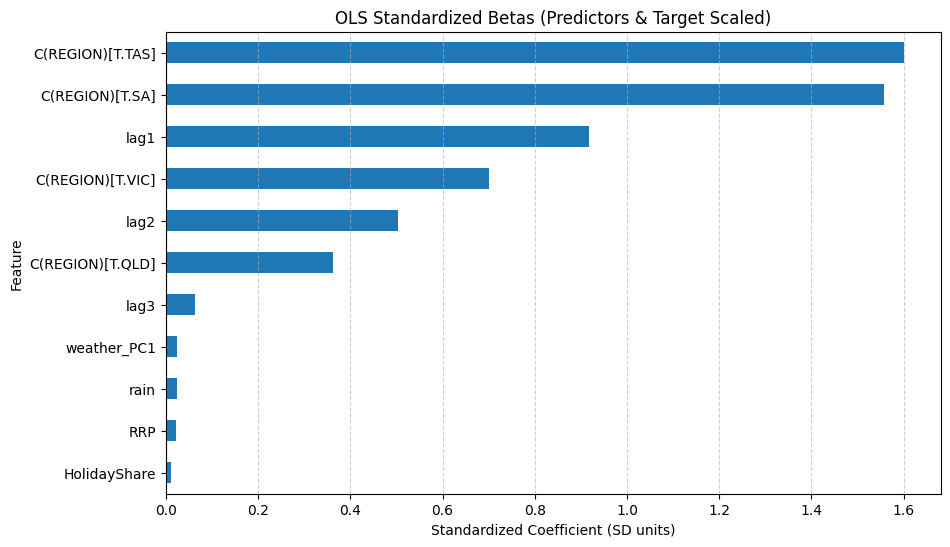

In [71]:
coefs = pooled_model_std.params.drop("Intercept", errors="ignore").sort_values(key=lambda x: abs(x), ascending=False)

plt.figure(figsize=(10,6))
np.abs(coefs).plot(kind="barh")
plt.title("OLS Standardized Betas (Predictors & Target Scaled)")
plt.xlabel("Standardized Coefficient (SD units)")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()

- State identity (REGION dummies) is the biggest driver → demand patterns are very different between states.

- Past demand (lags) is the next strongest driver → electricity usage is persistent and autocorrelated.

- Weather, holidays, and price have very little impact once region + history are included.

==> For forecasting model, region and lagged demand should be starting point. Weather/holiday can help at the margin, but they’re not the main story.

In [72]:
# Get predictions with confidence intervals for test set
pred_test = pooled_model_std.get_prediction(test_df)
pred_summary = pred_test.summary_frame(alpha=0.05)  # 95% CI

# Extract
y_test_pred_ci = scaler_y.inverse_transform(pred_summary["mean"].values.reshape(-1,1)).ravel()
ci_lower = scaler_y.inverse_transform(pred_summary["obs_ci_lower"].values.reshape(-1,1)).ravel()
ci_upper = scaler_y.inverse_transform(pred_summary["obs_ci_upper"].values.reshape(-1,1)).ravel()

# Put into DataFrame aligned with test index
ci_df = pd.DataFrame({
    "pred": y_test_pred_ci,
    "lower": ci_lower,
    "upper": ci_upper
}, index=test_df.index)


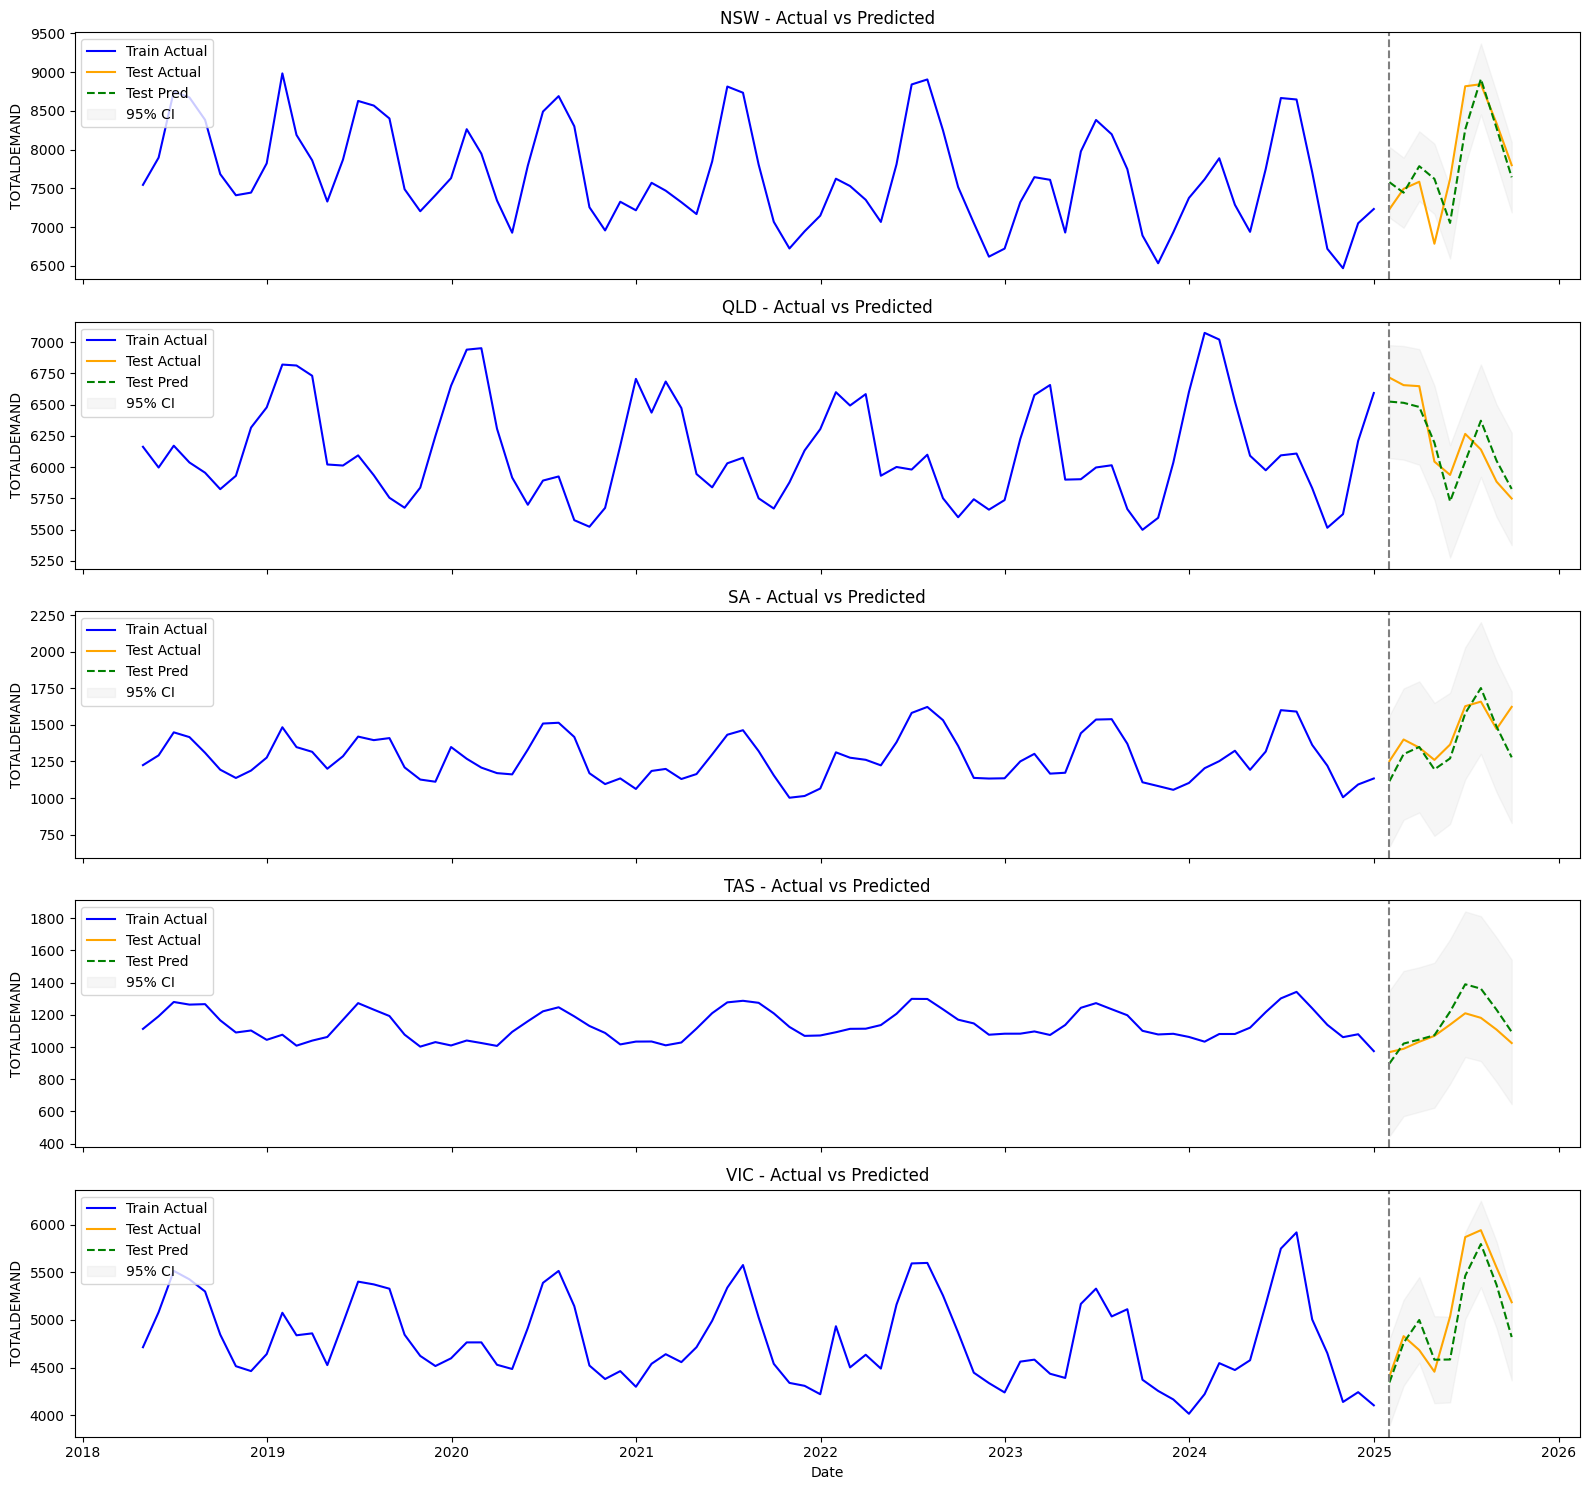

In [73]:
regions = df_monthly["REGION"].unique()

fig, axes = plt.subplots(len(regions), 1, figsize=(16, 3*len(regions)), sharex=True)

for i, region in enumerate(regions):
    ax = axes[i]
    idx_train = train_df["REGION"] == region
    idx_test = test_df["REGION"] == region

    # Actuals
    ax.plot(y_train_true[idx_train].index, y_train_true[idx_train],
             label="Train Actual", color="blue")
    ax.plot(y_test_true[idx_test].index, y_test_true[idx_test],
             label="Test Actual", color="orange")

    # Predictions
    ax.plot(ci_df.loc[idx_test].index, ci_df.loc[idx_test, "pred"],
             linestyle="--", color="green", label="Test Pred")

    # Confidence interval shading
    ax.fill_between(ci_df.loc[idx_test].index,
                    ci_df.loc[idx_test, "lower"],
                    ci_df.loc[idx_test, "upper"],
                    color="lightgray", alpha=0.2, label="95% CI")

    # Train/test split line
    ax.axvline(test_df.index.min(), color="gray", linestyle="dashed")

    ax.set_title(f"{region} - Actual vs Predicted")
    ax.set_ylabel("TOTALDEMAND")
    ax.legend(loc='upper left')

plt.xlabel("Date")
plt.tight_layout()
plt.show()
